In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("Traffic.ipynb")

# Final Project: Traffic
## Due Date: Monday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions within your own groups**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.

# Data 100 Final Project: Traffic in a post-lockdown world

**Scenario:** You're a data scientist at Uber -- sitting in a war room on March 16, 2020, 1 day after California-wide COVID lockdown measures began and the day shelter-in-place measures are announced in the bay area. The entire data science department is on fire: All of your existing traffic models have regressed *significantly*. Given the sudden change in traffic patterns (i.e., no traffic at all), the company's traffic estimates are wildly incorrect. This is a top priority for the company. Since traffic estimates are used directly for pricing strategies, this is actively costing the company millions every hour. You are tasked with fixing these models.

**Takeaways:** How do you "fix" models that have learned biases from pre-lockdown traffic? How do you train new ones, with just 24 hours of data? What sorts of data do you examine, to better understand the situation? In the midst of company-wide panic, you'll need a strong inferential acumen to lead a robust data science response. In this project, we'll walk you through a simulated war room data science effort, culminating in some strategies to fix models online, which are experiencing large distributional shifts in data.

For this project, we'll explore traffic data provided by the **Uber Movement** dataset, specifically around the start of COVID shutdowns in March 2020. Your project is structured around the following ideas:

```
1. Guided data cleaning: Clustering data spatially
    a. Load Uber traffic speeds dataset
    b. Map traffic speeds to Google Plus Codes (spatially uniform)
        i. Load node-to-gps-coordinates data
        ii. Map traffic speed to GPS coordinates
        iii. Convert GPS coordinates to plus code regions
        iv. Sanity check number of plus code regions in San Francisco
        v. Plot a histogram of the standard deviation in speed, per plus code region.
    c. Map traffic speeds to census tracts (spatially non-uniform)
        i. Download census tracts geojson
        ii. Map traffic speed to census tracts
        iii. Sanity check number of census tracts in San Francisco with data.
        iv. Plot a histogram of the standard deviation in speed, per census tract.
    d. What defines a "good" or "bad" spatial clustering?
2. Guided EDA: Understanding COVID lockdown impact on traffic
    a. How did lockdown affect average traffic speeds?
        i. Sort census tracts by average speed, pre-lockdown.
        ii. Sort census tracts by average speed, post-lockdown.
        iii. Sort census tracts by change in average speed, from pre to post lockdown.
        iv. Quantify the impact of lockdown on average speeds.
        v. Quantify the impact of pre-lockdown average speed on change in speed.
    b. What traffic areas were impacted by lockdown?
        i. Visualize heatmap of average traffic speed per census tract, pre-lockdown.
        ii. Visualize change in average daily speeds pre vs. post lockdown.
        iii. Quantify the impact of lockdown on daily speeds, spatially.
3. Open-Ended EDA: Understanding lockdown impact on traffic times
    a. Download Uber Movement (Travel Times) dataset
4. Guided Modeling: Predict traffic speed post-lockdown
    a. Predict daily traffic speed on pre-lockdown data
        i. Assemble dataset to predict daily traffic speed.
        ii. Train and evaluate linear model on pre-lockdown data.
    b. Understand failures on post-lockdown data
        i. Evaluate on post-lockdown data
        ii. Report model performance temporally
    c. "Fix" model on post-lockdown data
        i. Learn delta off of a moving bias
        ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?
        iii. Naively retrain model with post-lockdown data
        iv. What if you just ignore the change point?
5. Open-Ended Modeling: Predicting travel times post-lockdown
```

Concepts tested: regex, pivot, join, grouping, inferential thinking

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import csv
import json
import os
import contextily as cx
from collections import defaultdict
import re
from typing import Callable

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from zipfile import ZipFile
zf = ZipFile('data.zip', 'r')
zf.extractall('.')

# more readable exceptions
%pip install --quiet iwut
%load_ext iwut
%wut on

Note: you may need to restart the kernel to use updated packages.


# Step 1 - Guided Data Cleaning: Partitioning Data Spatially

Our hope is answer: How do we group information spatially? We'll specifically look at 2 ways of partitioning data spatially, to understand the impact of spatial partitioning strategies on our analyses:

1. Dividing the world uniformly into slices, like Google's plus codes.
2. Dividing the world according to population, using census tracts.

In this step, we'll load the following datasets that we'll need for this project:

- Daily travel times from Uber Movement data in March 2020 from San Francisco, by census tract
- Daily traffic speeds from Uber Movement data in Q1 2020 from San Francisco, between OSM nodes
- Census tracts dividing San Francisco by GPS coordinates
- Mapping from OSM nodes to GPS coordinates

There are several terms and concepts to get familiar with upfront:

- **Open Street Maps (OSM)** provides nodes (points in space, [wiki](https://wiki.openstreetmap.org/wiki/Node)) and ways (segments between nodes [wiki](https://wiki.openstreetmap.org/wiki/Way)). These IDs are used in the Uber Movement dataset to identify streets in the traffic speeds dataset.
- **Census Tracts** provided by the county of San Francisco geographically divides space according to the US 2010 Census. This is used in the Uber Movement dataset to identify regions of differing travel times.

## 1.a. Load Uber traffic speeds dataset

The dataset is located at `data/movement-speeds-daily-san-francisco-2020-3.csv`. **Load this dataset into a dataframe.**

*The original dataset from Uber was provided hourly and took up 2.1 GB on disk, which means it couldn't fit into your 1GB of RAM. You can find the dataset preparation script at `data/PrepareTrafficDataset.ipynb` which aggregated within each day, reducing the dataset to just 55MB on disk.*

*This was originally going to be question in this project, but it takes 22 minutes to run. Better yet, if you mess up, your kernel dies and you start over. We deemed it too frustrating and preprocessed the dataset to spare you the pain... but just know that this is a real-world issue!*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [3]:
# Load Uber Movement (Movement Speeds) dataset into dataframe
path_traffic_speeds = 'data/movement-speeds-daily-san-francisco-2020-3.csv'
speeds_to_nodes = pd.read_csv(path_traffic_speeds)

speeds_to_nodes

,osm_start_node_id,osm_end_node_id,day,speed_mph_mean
0,281266,702258940,1,59.674042
1,281266,702274215,1,68.444042
2,302876,240259516,1,66.446500
3,302878,437325360,1,65.516850
4,302883,65381191,1,61.880556
...,...,...,...,...
1586647,6569140748,1350115374,31,68.484833
1586648,6570476556,4551993266,31,36.837000
1586649,6573249373,4911384010,31,39.021000
1586650,6573553681,256888796,31,68.728333


In [4]:
grader.check("q1a")

q1a results: All test cases passed!

<!-- BEGIN QUESTION -->

## 1.b. Map traffic speed to Google Plus Codes

Google Plus Codes divide up the world uniformly into rectangular slices ([link](https://maps.google.com/pluscodes/)). Let's use this to segment traffic speeds spatially. Take a moment to answer: **Is this spatial structure effective for summarizing traffic speed?** Before completing this section, substantiate your answer with examples of your expectations (e.g., we expect A to be separated from B). After completing this section, substantiate your answer with observations you've made.

<!--
BEGIN QUESTION
name: q1b
points: 2
manual: True
-->

_Google Plus codes do not account for population densities, while census tracts do._

<!-- END QUESTION -->



### 1.b.i. Load Node-to-GPS-Coordinate Data

In this substep, we'll load a mapping from OSM nodes to GPS coordinates. The dataset is provided in a gzip'ed XML file from OpenStreetMaps (OSM). The mapping from OSM nodes to GPS coordinates was downloaded from https://download.bbbike.org/osm/bbbike/SanFrancisco/SanFrancisco.osm.gz. We've downloaded this for you, to avoid any issues with OSM updates.

**If** you try to load the provided `.osm` (an `.xml` in disguise) using Python's built-in XML utilities **(by uncommenting the last 2 lines in the below cell)**, you will hit an out-of-memory error, as your kernel is forced to restart.

In [5]:
# [OSM] - Read the OSM XML and extract mapping from node ID to GPS coordinates
PATH_OSM = os.path.expanduser('data/SanFrancisco.osm')

# Runs out of memory! File itself is 430 MB, even when filtering out
# irrelevant rows, and remaining 3M rows are too expensive to parse,
# resulting in OOM

# import xml.etree.ElementTree as ET
# _tree = ET.parse(PATH_OSM)

Your above code hits a memory error, so instead, we will use our handy-dandy tool--regex--from earlier in the semester to load just the parts of the file that we need. **Given the XML snippet below, write a regex pattern to extract OSM node ID, latitude, and longitude.** (The first capture group should be node ID. The second should be latitude, and the third should be longitude.) A snippet of the XML is included below ([screenshot](https://extract.bbbike.org/extract-screenshots.html)):

```
<?xml version='1.0' encoding='UTF-8'?>
<osm version="0.6" generator="osmconvert 0.8.3">
    <bounds minlat="42.4543" minlon="-2.4761999" maxlat="42.4..."/>
    <node id="26861066" lat="42.471111" lon="-2.454722" version="..."/>
        <tag k="name" v="Camping La Playa"/>
        <tag k="tourism" v="camp_site"/>
        <tag k="operator" v="private"/>
        ...
    </node>
    <node id="34793287" lat="42.4713587" lon="-2.4510783" version="..."/>
        <tag k="created_by" v="JOSM"/>
    </node>
    <node id="34793294" lat="42.4610836" lon="-2.4303622" version="..."/>
    <node id="34793297" lat="42.4548363" lon="-2.4287657" version="..."/>
    ...
</osm>
```

In [6]:
# [OSM] - Read the OSM XML using a regex operation instead.
def read_node_lat_lon(path: str, pattern: str, line_condition: Callable):
    """
    Read the provided path line at a line. If the provided regex pattern
    has a match, return the grouped matches as items in a generator.
    
    :param path: Path to read data from
    :param pattern: Regex pattern to test against each line
    :param line_condition: function that returns if we should check regex
        against current line
    """
    with open(path) as f:
        for line in f:
            result = re.search(pattern, line)
            if result is not None and line_condition(result):
                yield int(result.group(1)), float(result.group(2)), float(result.group(3))

In [7]:
node_ids = set(speeds_to_nodes.osm_start_node_id) | set(speeds_to_nodes.osm_end_node_id)

NODE_PATTERN = r"<node id=\"(\d*)\" lat=\"(.*)\" lon=\"(-\d*.\d*)\""

node_to_gps = pd.DataFrame(read_node_lat_lon(
    PATH_OSM,
    pattern=NODE_PATTERN,
    line_condition=lambda result: int(result.group(1)) in node_ids
), columns=['osm_node_id', 'Latitude', 'Longitude'])
node_to_gps

,osm_node_id,Latitude,Longitude
0,26118026,37.675280,-122.389194
1,29891973,37.674935,-122.389130
2,29892598,37.716892,-122.398893
3,30033679,37.599877,-122.376497
4,30033686,37.642167,-122.405946
...,...,...,...
19139,6522255428,37.760543,-122.443563
19140,6522255492,37.759317,-122.444996
19141,6522764204,37.762163,-122.436143
19142,6522764212,37.756061,-122.436761


In [8]:
grader.check("q1bi")

q1bi results: All test cases passed!

### 1.b.ii. Map traffic speed to GPS coordinates.

Traffic speeds are currently connected to OSM nodes. You will then use the mapping from OSM nodes to GPS coordinates, to map traffic speeds to GPS coordinates. **Link each traffic speed measurement to the GPS coordinate of its starting node.**

**Note**: For simplicity, assume each segment is associated with the node it *starts* with. 

**Hint**: Not all nodes are included in the OSM node mapping. Make sure to ignore any nodes without valid GPS coordinates.

<!--
BEGIN QUESTION
name: q1bii
points: 3
-->

In [9]:
# Find mapping from traffic speeds to GPS coordinates
speeds_to_gps = speeds_to_nodes.merge(node_to_gps, left_on='osm_end_node_id', right_on='osm_node_id')
speeds_to_gps.rename(columns={'Latitude':'endLatitude', 'Longitude':'endLongitude'}, inplace=True)
speeds_to_gps = speeds_to_gps[['day', 'speed_mph_mean', 'endLatitude', 'endLongitude']]
speeds_to_gps.head()

,day,speed_mph_mean,endLatitude,endLongitude
0,1,64.478000,37.67381,-122.38993
1,2,62.868208,37.67381,-122.38993
2,3,62.211750,37.67381,-122.38993
3,4,62.192458,37.67381,-122.38993
4,5,61.913292,37.67381,-122.38993


In [10]:
speeds_to_gps.shape

(417633, 4)

In [11]:
grader.check("q1bii")

q1bii results:
    q1bii - 1 result:
        Test case passed!

    q1bii - 2 result:
        Trying:
            _mask = ((speeds_to_gps['osm_start_node_id'] == 26118026) * (speeds_to_gps['osm_end_node_id'] == 259458979) * (speeds_to_gps['day'] == 1))
        Expecting nothing
        **********************************************************************
        Line 1, in q1bii 1
        Failed example:
            _mask = ((speeds_to_gps['osm_start_node_id'] == 26118026) * (speeds_to_gps['osm_end_node_id'] == 259458979) * (speeds_to_gps['day'] == 1))
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3361, in get_loc
                return self._engine.get_loc(casted_key)
              File "pandas/_libs/index.pyx", line 76, in pandas._libs.index.IndexEngine.get_loc
              File "pandas/_libs/index.pyx", line 108, in pandas._libs.index.IndexEngine.get_loc
              File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
              File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
            KeyError: 'osm_start_node_id'

            The above exception was the direct cause of the following exception:

            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1bii 1[0]>", line 1, in <module>
                _mask = ((speeds_to_gps['osm_start_node_id'] == 26118026) * (speeds_to_gps['osm_end_node_id'] == 259458979) * (speeds_to_gps['day'] == 1))
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py", line 3458, in __getitem__
                indexer = self.columns.get_loc(key)
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3363, in get_loc
                raise KeyError(key) from err
            KeyError: 'osm_start_node_id'
        Trying:
            _row = speeds_to_gps[_mask]
        Expecting nothing
        **********************************************************************
        Line 2, in q1bii 1
        Failed example:
            _row = speeds_to_gps[_mask]
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1bii 1[1]>", line 1, in <module>
                _row = speeds_to_gps[_mask]
            NameError: name '_mask' is not defined
        Trying:
            lat, lon = _row[['Latitude', 'Longitude']].values[0]
        Expecting nothing
        **********************************************************************
        Line 3, in q1bii 1
        Failed example:
            lat, lon = _row[['Latitude', 'Longitude']].values[0]
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1bii 1[2]>", line 1, in <module>
                lat, lon = _row[['Latitude', 'Longitude']].values[0]
            NameError: name '_row' is not defined
        Trying:
            (lat == 37.6752805) and (lon == -122.3891936) # test if you correctly mapped nodes to GPS coords
        Expecting:
            True
        **********************************************************************
        Line 4, in q1bii 1
        Failed example:
            (lat == 37.6752805) and (lon == -122.3891936) # test if you correctly mapped nodes to GPS coords
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 13

### 1.b.iii. Convert GPS coordinates to plus code regions.

Plus code regions divide up the world into uniformly-sized rectangles, which we will assume is 0.012 degrees latitudiunally and longitudinally. **For each traffic speed row, compute the plus code region it belongs to**, based on its GPS coordinates.

To do this, we suggest computing a latitudinal index `plus_latitude_idx` and a longitudinal index `plus_longitude_idx` for the plus code region each row belongs to. *Make sure these columns are integer-valued*.

**Hint**: If you're running into nans, you did 1.b.ii. incorrectly!

<!--
BEGIN QUESTION
name: q1biii
points: 3
-->

In [12]:
speeds_to_gps['plus_latitude_idx'] = (speeds_to_gps['endLatitude'] / 0.012).astype('int')
speeds_to_gps['plus_longitude_idx'] = (speeds_to_gps['endLongitude'] / 0.012).astype('int')

speeds_to_gps

,day,speed_mph_mean,endLatitude,endLongitude,plus_latitude_idx,plus_longitude_idx
0,1,64.478000,37.673810,-122.389930,3139,-10199
1,2,62.868208,37.673810,-122.389930,3139,-10199
2,3,62.211750,37.673810,-122.389930,3139,-10199
3,4,62.192458,37.673810,-122.389930,3139,-10199
4,5,61.913292,37.673810,-122.389930,3139,-10199
...,...,...,...,...,...,...
417628,19,34.393000,37.733635,-122.507100,3144,-10208
417629,19,40.802000,37.732039,-122.507126,3144,-10208
417630,20,36.076000,37.732039,-122.507126,3144,-10208
417631,19,39.592000,37.732418,-122.507206,3144,-10208


In [13]:
grader.check("q1biii")

q1biii results: All test cases passed!

### 1.b.iv. Sanity check number of plus code regions in San Francisco.

**Compute the number of unique plus codes found in your dataset**. You're checking that the number isn't ridiculous, like 1, or 100,000 (SF is 231 sq mi, so 100k tracts would average 12 sq ft per tract).

If you followed the suggestion above, this is the number of unique `(plus_latitude_idx, plus_longitude_idx)` pairs.

<!--
BEGIN QUESTION
name: q1biv
points: 4
-->

In [14]:
# You're expecting 276 plus codes here. Don't just type "276" 
# below to pass the autograder. The goal is to sanity check your 
# dataframe!
num_pluscode_regions = speeds_to_gps.groupby(['plus_latitude_idx', 'plus_longitude_idx']).size().shape[0]
num_pluscode_regions

279

In [15]:
grader.check("q1biv")

q1biv results:
    q1biv - 1 result:
        Trying:
            num_pluscode_regions == 276
        Expecting:
            True
        **********************************************************************
        Line 1, in q1biv 0
        Failed example:
            num_pluscode_regions == 276
        Expected:
            True
        Got:
            False

<!-- BEGIN QUESTION -->

### 1.b.v. How well do plus code regions summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "plus code region" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use the statistics above to answer these questions, and compute any additional statistics you need. Additionally explain *why these questions are important to assessing the quality of a spatial clustering*.

**Hint**: Run the autograder first to ensure your variance average and average variance are correct, before starting to draw conclusions.

In the first cell, write your written answers. In the second cell, complete the code.

<!--
BEGIN QUESTION
name: q1bv1
points: 2
manual: True
-->



_Being that plus codes are strictly geographically determined and do not take population into account, they may not as effectively capture meaningful subpopulations. Still, variance in speeds between subpopulations outweigh variance within a population (10.135 to 8.684)._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1bv2
points: 2
manual: True
-->

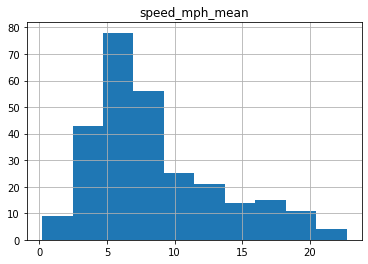

In [16]:
speed_variance_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx', 'plus_longitude_idx']).agg(np.std) # compute traffic speed variance in each plus code region
# plot a histogram
speed_variance_by_pluscode.hist(column='speed_mph_mean')
average_variance_by_pluscode = speed_variance_by_pluscode['speed_mph_mean'].mean()
variance_average_by_pluscode = speeds_to_gps.groupby(['plus_latitude_idx', 'plus_longitude_idx']).agg(np.mean)['speed_mph_mean'].std()

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1bv3
points: 3
-->

In [17]:
speed_variance_by_pluscode

day  speed_mph_mean  endLatitude  \
plus_latitude_idx plus_longitude_idx                                          
3128              -10209              3.089572        3.884747     0.001956   
                  -10197              8.047683       20.163375     0.001875   
                  -10193              4.523467       13.392039     0.000713   
3129              -10209              4.228332        3.752271     0.000000   
                  -10198              8.366557       20.282493     0.001782   
...                                        ...             ...          ...   
3160              -10197              6.852325       15.434435     0.000892   
                  -10196              6.142980       17.743211     0.002428   
                  -10195              6.367687       14.101576     0.002435   
                  -10194              6.656663       12.230629     0.001636   
                  -10193              8.077084       17.662046     0.001554   

                                      endLongitude  
plus_latitude_idx plus_longitude_idx                
3128              -10209                  0.001146  
                  -10197                  0.002004  
                  -10193                  0.001419  
3129              -10209                  0.000000  
                  -10198                  0.000831  
...                                            ...  
3160              -10197                  0.003001  
                  -10196                  0.002723  
                  -10195                  0.002523  
                  -10194                  0.002861  
                  -10193                  0.001888  

[279 rows x 4 columns]

In [18]:
grader.check("q1bv3")

q1bv3 results:
    q1bv3 - 1 result:
        Trying:
            np.isclose(average_variance_by_pluscode * variance_average_by_pluscode, 88.0263384096034)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1bv3 0
        Failed example:
            np.isclose(average_variance_by_pluscode * variance_average_by_pluscode, 88.0263384096034)
        Expected:
            True
        Got:
            False

    q1bv3 - 2 result:
        Trying:
            len(speed_variance_by_pluscode) == 276
        Expecting:
            True
        **********************************************************************
        Line 1, in q1bv3 1
        Failed example:
            len(speed_variance_by_pluscode) == 276
        Expected:
            True
        Got:
            False

## 1.c. Map traffic speed to census tract.

Census tracts divide the space much less uniformly, subdividing regions that we were interested in into smaller zones. This suggests promise in providing informative spatial segments. Note that the daily traffic speeds are provided between OpenStreetMap (OSM) nodes, so we'll need to map nodes to census tracts somehow.

Above, we've mapped traffic speeds to GPS coordinates. Below, we'll then link GPS coordinates to census tracts, to complete the mapping from traffic speeds to census tracts.

### 1.c.i. Download Census Tracts Geojson

**Load the census tracts geojson.** Make sure to see the relevant [geopandas io documentation](https://geopandas.org/docs/user_guide/io.html) to see how to load a geojson.

**Hint**: It should take you just one line to load.

<!--
BEGIN QUESTION
name: q1ci
points: 1
-->

In [19]:
PATH_TRACTS = os.path.expanduser('data/san_francisco_censustracts.json')
tract_to_gps = gpd.read_file(PATH_TRACTS)
tract_to_gps['MOVEMENT_ID'] = tract_to_gps['MOVEMENT_ID'].astype(int)
tract_to_gps

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."
...,...,...,...
2705,2706,"10000 Bobbell Drive, Elk Grove","MULTIPOLYGON (((-121.48392 38.40874, -121.4787..."
2706,2707,"400 Ericwood Court, Manteca","MULTIPOLYGON (((-121.22695 37.82647, -121.2185..."
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506..."
2708,2709,"1200 Halyard Drive, West Sacramento","MULTIPOLYGON (((-121.58346 38.57860, -121.5827..."


In [20]:
grader.check("q1ci")

q1ci results: All test cases passed!

### 1.c.ii Map traffic speed to census tracts.

You will need to *spatially join* the (1) mapping from traffic speed to GPS coordinates `speed_to_gps` and (2) the mapping from GPS coordinates to boundaries of census tracts `tract_to_gps` to group all traffic speeds by census tract. This "spatial join" is an advanced feature recently released (as of time of writing, in Oct 2021) in geopandas, which allows us to connect single points to their enclosing polygons. You will do this question in 3 parts:

1. Convert the last dataframe `speeds_to_gps` into a geopandas dataframe `speeds_to_points`, where GPS coordinates are now geopandas points. See this tutorial: https://geopandas.org/gallery/create_geopandas_from_pandas.html#From-longitudes-and-latitudes
2. Set the coordinate-system for the new geopandas dataframe to the "world geodesic system" [link](https://epsg.io/4326), or in other words, the coordinate system that GPS coordinates are reported in.
3. Compute a spatial join between census tracts `tract_to_gps` and the geopandas traffic speeds `speeds_to_points`

<!--
BEGIN QUESTION
name: q1cii
points: 4
-->

In [21]:
tract_to_gps.head()

,MOVEMENT_ID,DISPLAY_NAME,geometry
0,1,"Sargent Creek, San Ardo","MULTIPOLYGON (((-121.59511 36.11126, -121.5401..."
1,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...","MULTIPOLYGON (((-122.22463 37.46507, -122.2236..."
2,3,"18300 Sutter Boulevard, Morgan Hill","MULTIPOLYGON (((-121.67978 37.15859, -121.6719..."
3,4,"2700 Stoughton Way, Sheffield, Sacramento","MULTIPOLYGON (((-121.35921 38.57175, -121.3462..."
4,5,"3200 Huntsman Drive, Rosemont Park, Sacramento","MULTIPOLYGON (((-121.37512 38.55309, -121.3715..."


In [22]:
speeds_to_points = gpd.GeoDataFrame(speeds_to_gps, geometry=gpd.points_from_xy(speeds_to_gps.endLongitude, speeds_to_gps.endLatitude), crs=4326)
speeds_to_tract = tract_to_gps.sjoin(speeds_to_points)

speeds_to_tract

,MOVEMENT_ID,DISPLAY_NAME,geometry,index_right,day,speed_mph_mean,endLatitude,endLongitude,plus_latitude_idx,plus_longitude_idx
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149344,5,16.471333,37.786149,-122.417808,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149370,31,19.050500,37.786149,-122.417808,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149360,21,19.358000,37.786149,-122.417808,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149361,22,19.599000,37.786149,-122.417808,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149362,23,17.803000,37.786149,-122.417808,3148,-10201
...,...,...,...,...,...,...,...,...,...,...
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",405201,5,15.500333,37.661119,-122.438615,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",405197,3,11.906333,37.661119,-122.438615,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",405198,4,14.449000,37.661119,-122.438615,3138,-10203
2707,2708,"200 Westview Drive, Sunshine Gardens, South Sa...","MULTIPOLYGON (((-122.45179 37.66912, -122.4506...",405199,4,13.693333,37.661119,-122.438615,3138,-10203


In [23]:
grader.check("q1cii")

q1cii results:
    q1cii - 1 result:
        Trying:
            len(speeds_to_tract) == 418848
        Expecting:
            True
        **********************************************************************
        Line 1, in q1cii 0
        Failed example:
            len(speeds_to_tract) == 418848
        Expected:
            True
        Got:
            False

    q1cii - 2 result:
        Trying:
            _mask = ((speeds_to_tract['osm_start_node_id'] == 5429620647) * (speeds_to_tract['osm_end_node_id'] == 65333834) * (speeds_to_tract['day'] == 16))
        Expecting nothing
        **********************************************************************
        Line 1, in q1cii 1
        Failed example:
            _mask = ((speeds_to_tract['osm_start_node_id'] == 5429620647) * (speeds_to_tract['osm_end_node_id'] == 65333834) * (speeds_to_tract['day'] == 16))
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3361, in get_loc
                return self._engine.get_loc(casted_key)
              File "pandas/_libs/index.pyx", line 76, in pandas._libs.index.IndexEngine.get_loc
              File "pandas/_libs/index.pyx", line 108, in pandas._libs.index.IndexEngine.get_loc
              File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
              File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
            KeyError: 'osm_start_node_id'

            The above exception was the direct cause of the following exception:

            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1cii 1[0]>", line 1, in <module>
                _mask = ((speeds_to_tract['osm_start_node_id'] == 5429620647) * (speeds_to_tract['osm_end_node_id'] == 65333834) * (speeds_to_tract['day'] == 16))
              File "/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py", line 1327, in __getitem__
                result = super().__getitem__(key)
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py", line 3458, in __getitem__
                indexer = self.columns.get_loc(key)
              File "/opt/conda/lib/python3.9/site-packages/pandas/core/indexes/base.py", line 3363, in get_loc
                raise KeyError(key) from err
            KeyError: 'osm_start_node_id'
        Trying:
            _row = speeds_to_tract[_mask]
        Expecting nothing
        **********************************************************************
        Line 2, in q1cii 1
        Failed example:
            _row = speeds_to_tract[_mask]
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1cii 1[1]>", line 1, in <module>
                _row = speeds_to_tract[_mask]
            NameError: name '_mask' is not defined
        Trying:
            int(_row['MOVEMENT_ID']) == 9
        Expecting:
            True
        **********************************************************************
        Line 3, in q1cii 1
        Failed example:
            int(_row['MOVEMENT_ID']) == 9
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q1cii 1[2]>", line 1, in <module>
                int(_row['MOVEMENT_ID']) == 9
            NameError: name '_row' is not defined

### 1.c.iii. Aggregate movement speeds by census tract.

- Create a new dataframe `speeds_by_tract` to group movement speeds by census tract. See the outputted dataframe from 1.c.i. to check how census tracts are identified.
- Always double-check your numbers. **Report the number of census tracts** in your dataset.

<!--
BEGIN QUESTION
name: q1ciii
points: 2
-->

In [24]:
speeds_by_tract = speeds_to_tract.groupby('MOVEMENT_ID').mean()
num_census_tracts = speeds_by_tract.shape[0]

num_census_tracts

295

In [25]:
grader.check("q1ciii")

q1ciii results: All test cases passed!

<!-- BEGIN QUESTION -->

### 1.c.iv. How well do census tracts summarize movement speeds?

The following will give us an idea of how well the average represents traffic speed per plus code region. For these questions, we'll refer to a "census tract" as a "cluster":

1. **Plot a histogram of the within-cluster standard deviation**.
2. **Compute across-cluster average of within-cluster standard deviation**.
3. **Compute across-cluster standard deviation of within-cluster average speeds**.
4. **Is this average variance reasonable?** To assess what "reasonable" means, consider these questions and how to answer them: (1) Do plus codes capture meaningful subpopulations? (2) Do differences between subpopulations outweigh differences within a subpopulation? Use these ideas to assess whether the average standard deviation is high or not.

Note: We are using the speed metric of miles per hour here.

Just like before, please written answers in the first cell and coding answers in the second cell.
<!--5. Using the above, how would you **compare census tracts to plus codes, in terms of its effectiveness** as a spatial clustering mechanism for analyzing traffic speeds? Compare the statistics you've computed. What does it mean for one to be higher than the other?-->

<!--
BEGIN QUESTION
name: q1civ1
points: 2
manual: True
-->



_Census tracts capture meaningful subpopulations primarily because it is both determined geographically and by population according to the census. As a result, the variance within a subpopulation is lower than that using plus codes (8.300 to 8.684). Additionally, differences between subpopulations outweigh differences within a subpopulation (8.346 to 8.300), indicating individual clusters more accurately represent regions with different traffic speeds._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q1civ2
points: 2
manual: True
-->

In [26]:
speed_variance_by_tract = speeds_to_tract.groupby('MOVEMENT_ID').agg(np.std)
average_variance_by_tract = speed_variance_by_tract['speed_mph_mean'].mean()
variance_average_by_tract = speeds_to_tract.groupby('MOVEMENT_ID').agg(np.mean)['speed_mph_mean'].std()

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q1civ3
points: 3
-->

In [27]:
speed_variance_by_tract

,index_right,day,speed_mph_mean,endLatitude,endLongitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,
9,27137.579675,8.499717,3.688310,0.000797,0.000973,0.000000,0.000000
20,67322.900099,8.634339,5.495401,0.000473,0.002230,0.463547,0.000000
21,99039.871388,4.323334,3.533990,0.001159,0.001166,0.000000,0.000000
44,144441.020125,7.546902,7.054196,0.002519,0.002303,0.309566,0.384879
78,169982.140559,4.993603,4.011378,0.002939,0.003005,0.450127,0.498695
...,...,...,...,...,...,...,...
2691,2561.810461,3.854496,4.118630,0.002187,0.007621,0.000000,0.886405
2694,76391.205530,8.240210,5.989865,0.000749,0.003064,0.473799,0.000000
2695,156394.846165,5.791880,4.675039,0.001855,0.003582,0.000000,0.000000


In [28]:
grader.check("q1civ3")

q1civ3 results:
    q1civ3 - 1 result:
        Trying:
            np.isclose(average_variance_by_tract * variance_average_by_tract, 69.280110428793) or np.isclose(average_variance_by_tract * variance_average_by_tract, 69.16258683199653)
        Expecting:
            True
        **********************************************************************
        Line 1, in q1civ3 0
        Failed example:
            np.isclose(average_variance_by_tract * variance_average_by_tract, 69.280110428793) or np.isclose(average_variance_by_tract * variance_average_by_tract, 69.16258683199653)
        Expected:
            True
        Got:
            False

<!-- BEGIN QUESTION -->

## 1.d. What would be the ideal spatial clustering?

This is an active research problem in many spatiotemporal modeling communities, and there is no single agreed-upon answer. Answer both of the following specifically knowing that you'll need to analyze traffic patterns according to this spatial clustering:

1. **What is a good metric for a spatial structure?** How do we define good? Bad? What information do we expect a spatial structure to yield? Use the above parts and questions to help answer this.
2. **What would you do to optimize your own metric for success in a spatial structure?**

See related articles:

- Uber's H3 [link](https://eng.uber.com/h3/), which divides the world into hexagons
- Traffic Analysis Zones (TAZ) [link](https://en.wikipedia.org/wiki/Traffic_analysis_zone), which takes census data and additionally accounts for vehicles per household when dividing space

<!--
BEGIN QUESTION
name: q1d
points: 3
manual: True
-->

_A "good" metric for a spacial structure entails accurately dividing a region into parts that effectively captures its differences, in this case areas of different traffic speeds. This means that the variance within a cluster is relatively low while the variance between clusters is relatively high. Between plus codes and census tracts, the latter clearly seems to capture different traffic regions more effectively, as it takes population from the census into account. However, using a different metric, it may be helpful to explore dividing regions differently, such as the hexagonal structure in Uber's H3. According to their website, this would help "minimize quantization error introduced when users move through a city" and allow us to "approximate radiuses easily"._

<!-- END QUESTION -->



# Step 2 - Guided EDA: Understanding COVID Lockdown Impact on Traffic

In this step, we'll examine the impact of COVID on traffic. In particular, we'll study 3 different questions:

- How did lockdown affect traffic speed? What factors dictate how much lockdown affected traffic speed?
- What areas of traffic were most impacted by lockdown?

## 2.a. How did lockdown affect traffic speed?

<!-- BEGIN QUESTION -->

### 2.a.i. Sort census tracts by average speed, pre-lockdown.

Consider the pre-lockdown period to be March 1 - 13, before the first COVID-related restrictions (travel bans) were announced on March 14, 2020.

1. **Report a DataFrame which includes the *names* of the 10 census tracts with the lowest average speed**, along with the average speed for each tract.
2. **Report a DataFrame which includes the *names* of the 10 census tracts with the highest average speed**, along with the average speed for each tract.
2. Do these names match your expectations for low speed or high speed traffic pre-lockdown?  What relationships do you notice? (What do the low-speed areas have in common? The high-speed areas?) For this specific question, answer qualitatively. No need to quantify. **Hint**: Look up some of the names on a map, to understand where they are.
3. **Plot a histogram for all average speeds, pre-lockdown**.
4. You will notice a long tail distribution of high speed traffic. What do you think this corresponds to in San Francisco? Write down your hypothesis.

Hint: To start off, think about what joins may be useful to get the desired DataFrame.

<!--
BEGIN QUESTION
name: q2ai1
points: 3
manual: True
-->

_The long tail distribution of high speed traffic likely corresponds to the bridges and highways in San Francisco. Because commute to work was significantly cut down due to the the shelter in place, long distance commute through these areas probably saw a significant hit._

<!-- END QUESTION -->

Answer the following question:
<!--
BEGIN QUESTION
name: q2ai2
points: 3
-->

In [29]:
# compute the average speed per census tract (will use this later),
# BEFORE the shelter-in-place was announced on March 14, 2020.
# Autograder expects this to be a series
averages_pre = speeds_to_tract[speeds_to_tract['day'] < 14].groupby('MOVEMENT_ID').mean()['speed_mph_mean'] 
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_pre_named = speeds_to_tract[speeds_to_tract['day'] < 14].groupby('MOVEMENT_ID').mean() 
averages_pre_named

,index_right,day,speed_mph_mean,endLatitude,endLongitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,
9,128149.786260,6.969466,14.696778,37.785395,-122.415572,3148.000000,-10201.000000
20,99439.035129,7.060890,15.589538,37.787666,-122.418819,3148.313817,-10201.000000
21,174209.271565,6.753994,15.348598,37.801986,-122.437891,3150.000000,-10203.000000
44,197575.831214,6.894798,22.875865,37.723699,-122.397261,3143.139884,-10199.174566
78,227583.657080,6.486726,15.914150,37.729861,-122.388873,3143.716814,-10198.550885
...,...,...,...,...,...,...,...
2691,413990.375000,7.500000,18.478000,37.601912,-122.409783,3133.000000,-10200.250000
2694,98615.787975,6.931435,16.710688,37.787458,-122.429653,3148.275316,-10202.000000
2695,244981.299342,6.671053,19.795135,37.744142,-122.490476,3145.000000,-10207.000000


In [30]:
grader.check("q2ai2")

q2ai2 results:
    q2ai2 - 1 result:
        Test case passed!

    q2ai2 - 2 result:
        Trying:
            np.isclose(averages_pre.sum(), 6768.609943648161)
        Expecting:
            True
        **********************************************************************
        Line 1, in q2ai2 1
        Failed example:
            np.isclose(averages_pre.sum(), 6768.609943648161)
        Expected:
            True
        Got:
            False

Report the lowest 10 census tracts with the lowest average speed
Remember we want the NAME of each census tract too. For the autograder, please keep the name of the speed field, `speed_mph_mean`.

<!--
BEGIN QUESTION
name: q2ai3
points: 1
-->

In [31]:
bottom10_averages_pre = averages_pre_named.sort_values(by='speed_mph_mean').head(10)
bottom10_averages_pre

,index_right,day,speed_mph_mean,endLatitude,endLongitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,
1688,130969.148359,6.754636,13.143691,37.792748,-122.411651,3149.000000,-10200.419401
1244,127478.838762,6.695440,13.208118,37.793868,-122.408718,3149.000000,-10200.000000
1245,138795.978814,6.949153,13.211571,37.786764,-122.411725,3148.000000,-10200.440678
643,149190.810417,7.006250,13.319976,37.785092,-122.419499,3148.000000,-10201.000000
644,218623.651899,6.955696,13.459159,37.783512,-122.411850,3148.000000,-10200.493671
1691,171132.141509,6.855346,13.498544,37.785651,-122.410381,3148.000000,-10200.223270
1674,177531.241877,6.949458,13.500841,37.782658,-122.415224,3148.000000,-10201.000000
651,151822.575688,6.268349,13.534004,37.754965,-122.411819,3146.000000,-10200.584862
2340,184167.666667,6.916667,13.598146,37.782883,-122.410854,3148.000000,-10200.382353


In [32]:
grader.check("q2ai3")

q2ai3 results:
    q2ai3 - 1 result:
        Test case passed!

    q2ai3 - 2 result:
        Trying:
            np.isclose(bottom10_averages_pre['speed_mph_mean'].sum(), 132.8372935366123)
        Expecting:
            True
        **********************************************************************
        Line 1, in q2ai3 1
        Failed example:
            np.isclose(bottom10_averages_pre['speed_mph_mean'].sum(), 132.8372935366123)
        Expected:
            True
        Got:
            False

Report the highest 10 census tracts with the highest average speed.

<!--
BEGIN QUESTION
name: q2ai4
points: 1
-->

In [33]:
top10_averages_pre = averages_pre_named.sort_values(by='speed_mph_mean', ascending=False).head(10)
top10_averages_pre

,index_right,day,speed_mph_mean,endLatitude,endLongitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,
495,261516.811475,6.573770,57.174177,37.621635,-122.427365,3134.737705,-10202.000000
285,276563.000000,7.000000,52.746477,37.822485,-122.322972,3151.000000,-10193.000000
2339,315984.822064,6.330961,47.880862,37.593756,-122.417706,3132.206406,-10201.000000
1653,236111.057692,6.437500,47.504055,37.927343,-122.378093,3160.000000,-10197.729167
2244,318592.267974,5.535948,45.334418,37.551516,-122.358314,3128.601307,-10195.960784
2660,293433.512821,6.884615,44.389193,37.869714,-122.507260,3155.038462,-10208.076923
1744,278690.534161,6.968944,43.520816,37.597577,-122.419840,3132.919255,-10201.037267
1955,328598.793478,5.635870,43.109320,37.555688,-122.514656,3129.005435,-10209.000000
1732,282464.411899,6.782609,39.739618,37.676023,-122.488311,3139.077803,-10206.970252


In [34]:
grader.check("q2ai4")

q2ai4 results:
    q2ai4 - 1 result:
        Trying:
            np.isclose(top10_averages_pre['speed_mph_mean'].sum(), 463.8706591327185)
        Expecting:
            True
        **********************************************************************
        Line 1, in q2ai4 0
        Failed example:
            np.isclose(top10_averages_pre['speed_mph_mean'].sum(), 463.8706591327185)
        Expected:
            True
        Got:
            False

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2ai5
points: 1
manual: True
-->

<AxesSubplot:>

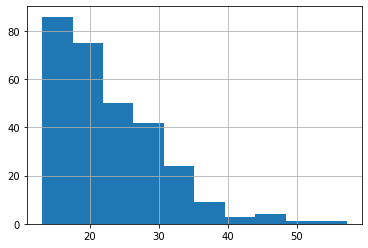

In [35]:
averages_pre_named['speed_mph_mean'].hist()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.ii. Sort census tracts by average speed, post-lockdown.

I suggest checking the top 10 and bottom 10 tracts by average speed, post-lockdown. Consider the post-lockdown period to be March 14 - 31, after the first COVID restrictions were established on March 14, 2020. It's a healthy sanity check. For this question, you should report:

- **Plot a histogram for all average speeds, post-lockdown.**
- **What are the major differences between this post-lockdown histogram relative to the pre-lockdown histogram above**? Anything surprising? What did you expect, and what did you find?

Write the written answers in the cell below, and the coding answers in the cells after that.

<!--
BEGIN QUESTION
name: q2aii1
points: 1
manual: True
-->

_Pre-lockdown speeds peaked at around 20 mph while post-lockdown speeds peaked at around 25 mph. Additionally, the distributition for pre-lockdown speeds saw a smoother decline when looking at higher speeds, whereas the distribution for post lockdown speeds saw a signficantly steeper dropoff at 30 mph._

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q2aii2
points: 2
-->

In [36]:
# compute the average speed per census tract (will use this later),
# AFTER (and including) the first COVID restrictions were put into effect.
# Autograder expects this to be a series
averages_post = speeds_to_tract[speeds_to_tract['day'] > 13].groupby('MOVEMENT_ID').mean()['speed_mph_mean'] 
# Autograder expects this to be a dataframe with name of census tract,
# polygon for census tract, and average speed per census tract
averages_post_named = speeds_to_tract[speeds_to_tract['day'] > 13].groupby('MOVEMENT_ID').mean()
averages_post_named

,index_right,day,speed_mph_mean,endLatitude,endLongitude,plus_latitude_idx,plus_longitude_idx
MOVEMENT_ID,,,,,,,
9,122322.596413,21.426009,16.753636,37.785612,-122.415746,3148.000000,-10201.000000
20,98051.750583,21.764569,16.844354,37.787671,-122.418697,3148.310023,-10201.000000
21,139637.340909,15.045455,16.650178,37.802372,-122.437731,3150.000000,-10203.000000
44,176459.117333,20.341333,24.785735,37.722600,-122.397495,3143.032000,-10199.194667
78,224192.666667,18.476190,15.482810,37.730548,-122.388207,3143.738095,-10198.452381
...,...,...,...,...,...,...,...
2673,152505.894468,21.715745,36.529433,37.744305,-122.406479,3144.668936,-10200.000000
2694,98902.979890,21.340037,21.499109,37.787835,-122.429149,3148.451554,-10202.000000
2695,182410.805556,17.888889,23.255800,37.744031,-122.492671,3145.000000,-10207.000000


In [37]:
grader.check("q2aii2")

q2aii2 results:
    q2aii2 - 1 result:
        Trying:
            np.isclose(averages_post.sum(), 8067.4526554466975)
        Expecting:
            True
        **********************************************************************
        Line 1, in q2aii2 0
        Failed example:
            np.isclose(averages_post.sum(), 8067.4526554466975)
        Expected:
            True
        Got:
            False

    q2aii2 - 2 result:
        Trying:
            len(averages_post) == 285
        Expecting:
            True
        **********************************************************************
        Line 1, in q2aii2 1
        Failed example:
            len(averages_post) == 285
        Expected:
            True
        Got:
            False

<!-- BEGIN QUESTION -->

Plot the histogram
<!--
BEGIN QUESTION
name: q2aii3
points: 1
manual: True
-->

<AxesSubplot:>

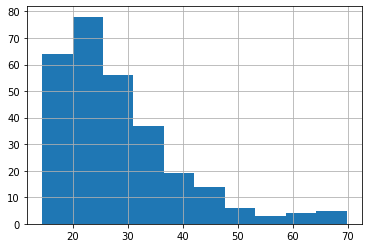

In [38]:
averages_post_named['speed_mph_mean'].hist()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iii. Sort census tracts by change in traffic speed from pre to post lockdown.

For each segment, compute the difference between the pre-lockdown average speed (March 1 - 13) and the post-lockdown average speed (March 14 - 31). **Plot a histogram of all differences.** Sanity check that the below histogram matches your observations of the histograms above, on your own.

<!--
BEGIN QUESTION
name: q2aiii
points: 2
manual: True
-->

<AxesSubplot:>

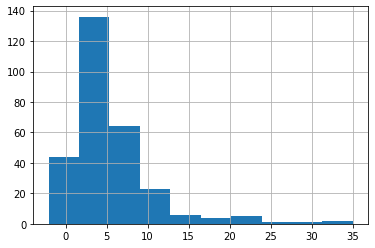

In [39]:
# The autograder expects differences to be a series object with index
# MOVEMENT_ID.
differences = averages_post - averages_pre
# plot the differences
differences.hist()

In [40]:
grader.check("q2aiii")

q2aiii results:
    q2aiii - 1 result:
        Trying:
            np.isclose(differences.sum(), 1526.2565260348706)
        Expecting:
            True
        **********************************************************************
        Line 1, in q2aiii 0
        Failed example:
            np.isclose(differences.sum(), 1526.2565260348706)
        Expected:
            True
        Got:
            False

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.a.iv. Quantify the impact of lockdown on average speeds.

1. **Plot the average speed by day, across all segments**. Be careful not to plot the average of census tract averages instead. Recall the definition of segments from Q1.
2. Is the change in speed smooth and gradually increasing? Or increasing sharply? Why? Use your real-world knowledge of announcements and measures during that time, in your explanation. You can use this list of bay area COVID-related dataes: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/

<!--
BEGIN QUESTION
name: q2aiv1
points: 1
manual: True
-->

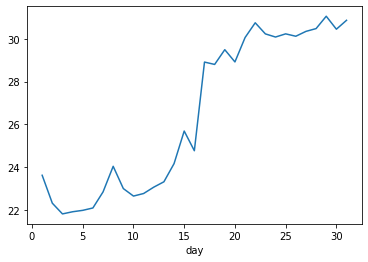

In [41]:
# Autograder expects this to be a series object containing the
# data for your line plot -- average speeds per day.
speeds_daily = speeds_to_tract.groupby('day').mean()['speed_mph_mean']
speeds_daily.plot();

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Write your written answer in the cell below

<!--
BEGIN QUESTION
name: q2aiv2
points: 1
manual: True
-->

_The change in speeds increases sharply around the 15th day, in which the shelter in place and COVID lockdowns were enforced._

<!-- END QUESTION -->

Ignore the empty cell below, just run the autograder to test the code above is correct.
<!--
BEGIN QUESTION
name: q2aiv3
points: 1
-->

In [42]:
grader.check("q2aiv3")

q2aiv3 results:
    q2aiv3 - 1 result:
        Test case passed!

    q2aiv3 - 2 result:
        Trying:
            np.isclose(speeds_daily.values[0], 23.63312757040251)
        Expecting:
            True
        **********************************************************************
        Line 1, in q2aiv3 1
        Failed example:
            np.isclose(speeds_daily.values[0], 23.63312757040251)
        Expected:
            True
        Got:
            False

<!-- BEGIN QUESTION -->

### 2.a.v. Quantify the impact of pre-lockdown average speed on change in speed.

1. Compute the correlation between change in speed and the *pre*-lockdown average speeds. Do we expect a positive or negative correlation, given our analysis above?
2. Compute the correlation between change in speed and the post-lockdown average speeds.
3. **How does the correlation in Q1 compare with the correlation in Q2?** You should expect a significant change in correlation value. What insight does this provide about traffic?

Written answers in the first cell, coding answerts in the following cell.

<!--
BEGIN QUESTION
name: q2av1
points: 2
manual: True
-->

_The correlation between change in speed and pre-lockdown average speeds is 0.463. We expect a positive correlation, as freeways and highways which were relatively slower pre-lockdown see a larger change while low-speed zones typically maintain the same average speed since people still need to get around. The correlation between change in speed and post-lockdown average speeds is 0.792. This correlation is significantly higher than the former, as speeds significantly appear to increase after the lockdowns were implemented._

<!-- END QUESTION -->


<!--
BEGIN QUESTION
name: q2av2
points: 2
-->

In [43]:
corr_pre_diff = differences.corr(averages_pre)
corr_post_diff = differences.corr(averages_post)
corr_pre_diff, corr_post_diff

(0.4781859372211733, 0.798697244624203)

In [44]:
grader.check("q2av2")

q2av2 results:
    q2av2 - 1 result:
        Trying:
            np.isclose(corr_pre_diff * corr_post_diff, 0.36724914907071704)
        Expecting:
            True
        **********************************************************************
        Line 1, in q2av2 0
        Failed example:
            np.isclose(corr_pre_diff * corr_post_diff, 0.36724914907071704)
        Expected:
            True
        Got:
            False

## 2.b. What traffic areas were impacted by lockdown?

<!-- BEGIN QUESTION -->

### 2.b.i. Visualize spatial heatmap of average traffic speed per census tract, pre-lockdown.

Visualize a spatial heatmap of the grouped average daily speeds per census tract, which you computed in previous parts. Use the geopandas [chloropleth maps](https://geopandas.org/docs/user_guide/mapping.html#choropleth-maps). **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest**. These may be a local extrema, or a region that is strangely all similar.

**Hint**: Use [`to_crs`](https://geopandas.org/docs/reference/api/geopandas.GeoDataFrame.to_crs.html) and make sure the `epsg` is using the Pseudo-Mercator projection.

**Hint**: You can use `contextily` to superimpose your chloropleth map on a real geographic map.

**Hint** You can set a lower opacity for your chloropleth map, to see what's underneath, but be aware that if you plot with too low of an opacity, the map underneath will perturb your chloropleth and meddle with your conclusions.

Written answers in the first cell, coding answers in the second cell.

<!--
BEGIN QUESTION
name: q2bi1
points: 1
manual: True
-->

_One area of interest is a local extrema at Mill Valley, in which the region contains a lower average speed than its surroundings. Additionally, the northeastern region of San Francisco which contain primarily tourist attractions are relatively slow on average._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bi2
points: 4
manual: True
-->

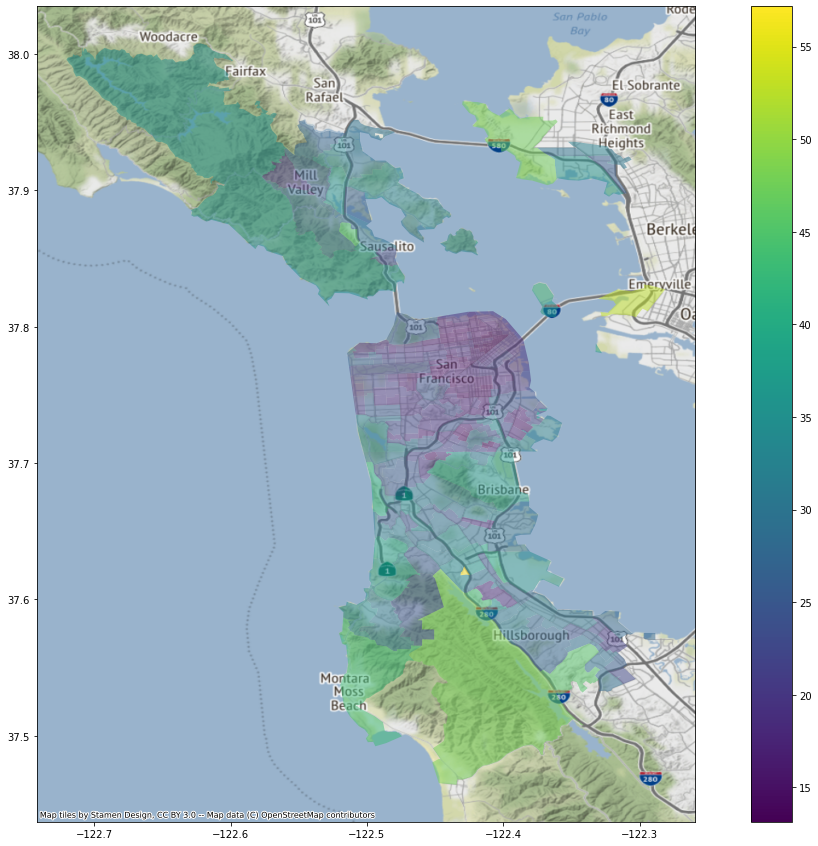

In [45]:
pre_geom = averages_pre_named.merge(speeds_to_tract[['MOVEMENT_ID', 'geometry']], left_on='MOVEMENT_ID', right_on='MOVEMENT_ID').drop_duplicates()
heatmap = pre_geom.plot(column='speed_mph_mean', figsize=(20, 15), legend=True, alpha=0.5)
cx.add_basemap(heatmap, crs=pre_geom.crs)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 2.b.ii. Visualize change in average daily speeds pre vs. post lockdown.

Visualize a spatial heatmap of the census tract differences in average speeds, that we computed in a previous part. **Write your observations, using your visualization, noting down at least 2 areas or patterns of interest.** Some possible ideas for interesting notes: Which areas saw the most change in average speed? Which areas weren't affected? Why did some areas see *reduced* average speed?

First cell is for the written answers, second cell is for the coding answers.

<!--
BEGIN QUESTION
name: q2bii1
points: 1
manual: True
-->

_High density regions in San Francisco saw a relatively low change to speeds on average, probably due to the fact that regardless of the shelter in place, people needed to get around for get around for basic services. We also see a local extrema at Hillsborough, which saw a difference of nearly 35 mph._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!--
BEGIN QUESTION
name: q2bii2
points: 4
manual: True
-->

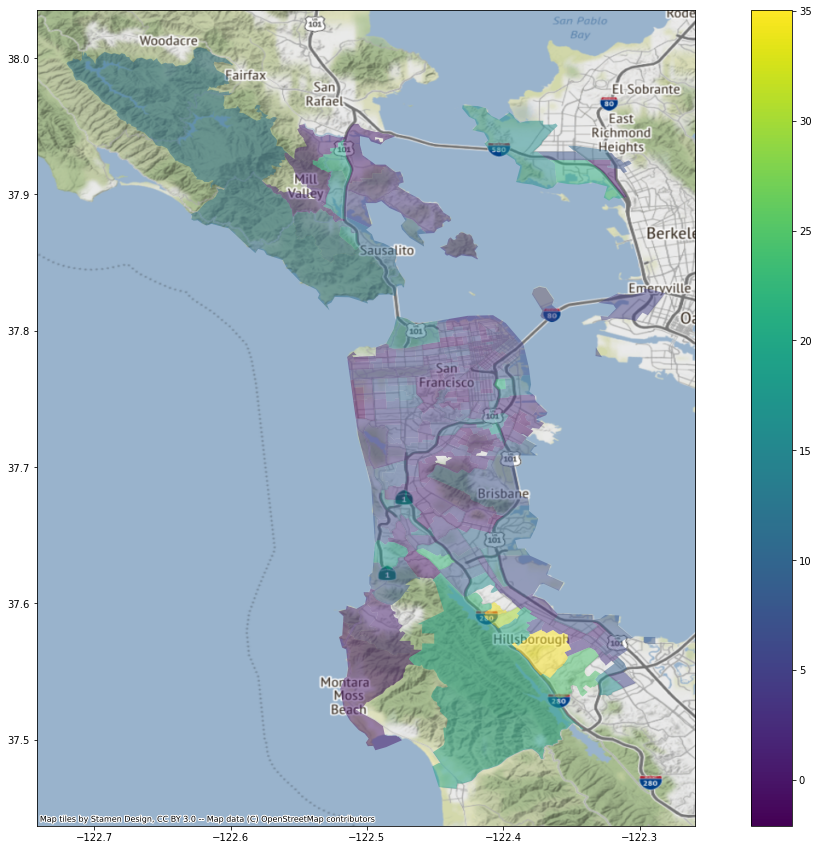

In [46]:
post_geom = speeds_to_tract[['MOVEMENT_ID', 'geometry']].merge(differences.to_frame(), on='MOVEMENT_ID').drop_duplicates()
heatmap_dif = post_geom.plot(column='speed_mph_mean', figsize=(20, 15), legend=True, alpha=0.5)
cx.add_basemap(heatmap_dif, crs=post_geom.crs)

<!-- END QUESTION -->



# Step 3 - Open-Ended EDA: Understanding lockdown impact on travel times

Explore daily travel times from Hayes Valley to other destinations both before and throughout lockdown. Use the following questions as suggestions for what to explore, temporally and spatially:

- How did lockdown affect travel times? Are there any meaningful factors that determined how travel time would be impacted? How was travel time affected over time?
- Travel to which destinations were affected by lockdown? Are there surprisingly disproportionate amounts of impact in certain areas?

## 3.a. Load Datasets

In this step, we will load two datasets:

- Daily travel times from Hayes Valley to all other census tracts around San Francisco.
- Daily travel times from 300 Hayes St to Golden Gate Park in San Francisco.

For this specific set of data, we can ask several more questions; which questions you pursue are up to you, including any that you come up that are not on this list:

- Which routes from Hayes Valley had similar impact on travel time? Did they share any factors in common? Traveling through the same place -- e.g., a freway? Traveling in similar areas e.g., residential areas?
- Were clusters of routes impacted more severely than others over time? What determined the degree of impact?

In [47]:
speeds_to_tract.head()

,MOVEMENT_ID,DISPLAY_NAME,geometry,index_right,day,speed_mph_mean,endLatitude,endLongitude,plus_latitude_idx,plus_longitude_idx
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149344,5,16.471333,37.786149,-122.417808,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149370,31,19.050500,37.786149,-122.417808,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149360,21,19.358000,37.786149,-122.417808,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149361,22,19.599000,37.786149,-122.417808,3148,-10201
8,9,"500 Hyde Street, Tenderloin, San Francisco","MULTIPOLYGON (((-122.41827 37.78704, -122.4150...",149362,23,17.803000,37.786149,-122.417808,3148,-10201


In [48]:
PATH_TIMES = 'data/travel-times-daily-san-francisco-2020-3.csv'
times_to_tract = pd.read_csv(PATH_TIMES)
times_to_tract

,Origin Movement ID,Origin Display Name,Destination Movement ID,Destination Display Name,Date Range,Mean Travel Time (Seconds),Range - Lower Bound Travel Time (Seconds),Range - Upper Bound Travel Time (Seconds),day
0,1277,"300 Hayes Street, Civic Center, San Francisco",9,"500 Hyde Street, Tenderloin, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",322,211,489,1
1,1277,"300 Hayes Street, Civic Center, San Francisco",20,"900 Sutter Street, Lower Nob Hill, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",291,179,470,1
2,1277,"300 Hayes Street, Civic Center, San Francisco",21,"3400 Pierce Street, Marina District, San Franc...","3/1/2020 - 3/1/2020, Every day, Daily Average",635,438,920,1
3,1277,"300 Hayes Street, Civic Center, San Francisco",44,"1700 Egbert Avenue, Bayview, San Francisco","3/1/2020 - 3/1/2020, Every day, Daily Average",786,566,1090,1
4,1277,"300 Hayes Street, Civic Center, San Francisco",46,"500 Chester Street, West Oakland, Oakland","3/1/2020 - 3/1/2020, Every day, Daily Average",891,682,1162,1
...,...,...,...,...,...,...,...,...,...
10333,1277,"300 Hayes Street, Civic Center, San Francisco",2624,"1300 16th Avenue, Inner Sunset, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",502,411,611,31
10334,1277,"300 Hayes Street, Civic Center, San Francisco",2643,"1300 Egbert Avenue, Bayview, San Francisco","3/31/2020 - 3/31/2020, Every day, Daily Average",571,475,685,31
10335,1277,"300 Hayes Street, Civic Center, San Francisco",2673,"100 Rutledge Street, Bernal Heights, San Franc...","3/31/2020 - 3/31/2020, Every day, Daily Average",367,265,507,31
10336,1277,"300 Hayes Street, Civic Center, San Francisco",2694,"1900 Buchanan Street, Western Addition, San Fr...","3/31/2020 - 3/31/2020, Every day, Daily Average",222,167,294,31


In [49]:
hayes_map = times_to_tract.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
hayes_map = gpd.GeoDataFrame(hayes_map)

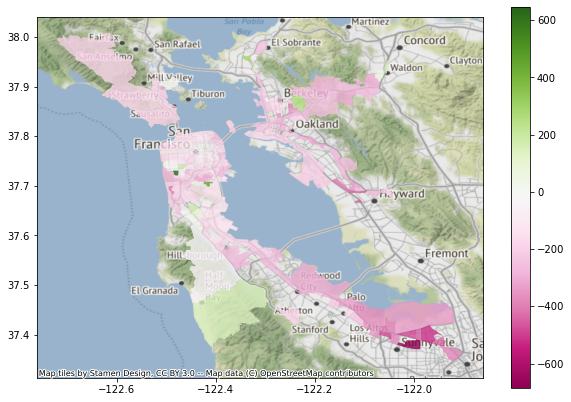

In [50]:
hayes_prelockdown = hayes_map[hayes_map['day'] < 14]
hayes_postlockdown = hayes_map[hayes_map['day'] > 14]
hayes_precovid_means = gpd.GeoDataFrame(hayes_prelockdown.groupby(['Destination Movement ID'])[['Mean Travel Time (Seconds)']].agg(np.mean).merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID'))
hayes_postlockdown_means = gpd.GeoDataFrame(hayes_postlockdown.groupby(['Destination Movement ID'])[['Mean Travel Time (Seconds)']].agg(np.mean).merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID'))
hayes_diff = hayes_precovid_means.merge(hayes_postlockdown_means, on='MOVEMENT_ID')
hayes_diff['Travel Time Difference'] = hayes_diff['Mean Travel Time (Seconds)_y'] - hayes_diff['Mean Travel Time (Seconds)_x']
hayes_diff['geometry'] = hayes_diff['geometry_x']
hayes_diff = gpd.GeoDataFrame(hayes_diff)
hayes_diff
diff_plot = hayes_diff.plot(column='Travel Time Difference', figsize=(10,7), legend=True, alpha=0.8, cmap='PiYG')
cx.add_basemap(diff_plot, crs=hayes_diff.crs)

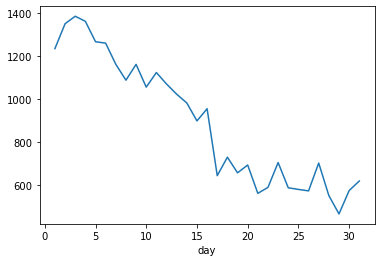

In [51]:
hayes_speeds = times_to_tract.groupby('day').mean()["Mean Travel Time (Seconds)"]
hayes_speeds.plot();

In [52]:
import seaborn as sns
hayes_map = times_to_tract.merge(tract_to_gps, left_on='Destination Movement ID', right_on='MOVEMENT_ID')
hayes_map = gpd.GeoDataFrame(hayes_map)

def dest_dist(destination_ids, data):
    for destination_id in destination_ids:
        dest_map = data[data['Destination Movement ID']==destination_id]
        sns.lineplot(data=dest_map, x='day', y='Mean Travel Time (Seconds)')

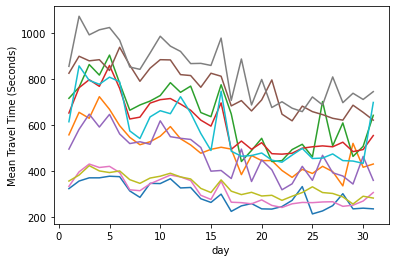

In [53]:
popular_destinations = hayes_map['Destination Movement ID'].value_counts()[:10].index.to_list()
dest_dist(popular_destinations, hayes_map)

# Step 4 - Guided Modeling: Predict traffic speed post-lockdown

In this step, you'll train a model to predict traffic speed. In particular, you'll learn how to provide implicit supervision and correction to your model, when you know there's been a distribution shift in its data, leading to a large gap between train and test sets. You'll follow the following outline:

- Build a model to predict daily traffic speed in San Francisco. Train and evaluate on *pre*-lockdown traffic speeds around the city.
- Evaluate your model on post-lockdown traffic speeds. Where is your model most mistaken, and why?
- Using this knowledge, how would you correct your model for a more accurate post-lockdown traffic predictor?


The technical term for a phenomenon like the lockdown, which caused major distributional shifts in the data, is *change point*. A large body of work studies "change point detection," but you'll be harder pressed to find a "handling change point" paper. 

## 4.a. Predict daily traffic speed on pre-lockdown data

For your model, you will predict daily traffic speed per census tract, given the previous $k=5$ daily traffic speeds for that census tract. In particular, say a matrix $A$ is $n \times d$, where $n$ is the number of census tracts and $d$ is the number of days. We define the following inputs and labels:

$$X_{(i,t)} = [A_{(i,t-5)}, A_{(i,t-4)}, A_{(i,t-3)}, A_{(i,t-2)}, A_{(i,t-1)}]$$
$$y_{(i,t)} = [A_{(i,t)}]$$

This just means that each sample $X_i$ includes speed averages from the previous 5 days for the $i$th census track.

### 4.a.i. Assemble dataset to predict daily traffic speed.

Below, we've included skeletons for the helper functions we defined, to complete the problem. We highly recommend following this skeleton code, else we cannot guarantee staff support for debugging your work.


**Hint**: What's wrong with collecting all samples, then randomly selecting some percentage to hold out? See the answer in the expandable below.

<details>
    <summary>[Click to expand] How to do train-validation split correctly, on time series</summary>
    
For a *time series* in particular, this random split would be cheating, because data within each day is highly correlated. Instead, you should hold out entire days from the dataset. In this case, you should hold out the last 2 days for your validation set.
</details>

<!--
BEGIN QUESTION
name: q4ai1
points: 1
-->

In [54]:
def dataframe_to_time_series(df: pd.DataFrame):
    """Convert your dataframe into a 'time series'.
    
    :param df: the original dataframe, mapping speeds to census tracts.
        This dataframe should contain the `MOVEMENT_ID` (census tract id),
        `day`, and average speed for that day `speed_mph_mean`
    :return: a new dataframe that is formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    """
    by_day = df.groupby(['MOVEMENT_ID', 'day']).mean().reset_index()
    time_series = by_day.pivot(index='MOVEMENT_ID', columns='day', values='speed_mph_mean')
    return time_series
time_series = dataframe_to_time_series(speeds_to_tract)
time_series_pre = time_series.iloc[:, list(range(13))]

In [55]:
grader.check("q4ai1")

In [ ]:
time_series.head()

In [ ]:
time_series.loc[:, :2]

In [ ]:
def time_series_to_numpy(df: pd.DataFrame, T: int, n_val: int):
    """Convert your 'time series' into train-validate splits, in numpy
    
    You can assume your dataframe contains a `day` column where days
    start from 1 and are consecutive.
    
    :param df: the dataframe formatted as n x d, where
        n is the number of samples (census tracts) and d is the number of
        dimensions (days). The values are the speeds.
    :param T: number of days to include in each training sample
    :param n_val: number of days to hold out for the validation set.
        Say we have 5 total days in our dataset, T=2, n_val=2. This means
        during training, we have samples that pull averages from days 1 and
        2 to predict day 3: x=(1, 2), y=(3,) For validation, we have samples
        like x=(2, 3), y=(4,) and x=(3, 4), y=(5,). This way, the model sees
        data from days 4 and 5 only during validation.
    :return: Set of 4 numpy arrays - X_train, y_train, X_val, y_val - where
        X_* arrays are (n, T) and y_* arrays are (n,).
    """
    X_train = []
    for i in np.arange(df.shape[1] - n_val - T):
        for j in np.arange(df.shape[0]):
            X_train.append(df.iloc[j, i:T+i])
    
    y_train = []
    for i in np.arange(T, df.shape[1] - n_val):
        for j in np.arange(df.shape[0]):
            y_train.append(df.iloc[j, i])
    
    X_val = []
    for i in np.arange(df.shape[1] - n_val - T, df.shape[1] - T):
        for j in np.arange(df.shape[0]):
            X_val.append(df.iloc[j, i:T+i])
    
    y_val = []
    for i in np.arange(df.shape[1] - n_val, df.shape[1]):
        for j in np.arange(df.shape[0]):
            y_val.append(df.iloc[j, i])
            
    return np.asarray(X_train, dtype="object"), np.asarray(y_train, dtype="object"), np.asarray(X_val, dtype="object"), np.asarray(y_val, dtype="object")


def remove_nans(X: np.array, y: np.array):
    """Remove all nans from the provided (X, y) pair.
    
    Note: A nan in X means that sample must be removed from *both X and y.
        Likewise, a nan in y means that sample must be removed from *both
        X and y.
    
    :param X: (n, T) array of model inputs
    :param y: (n,) array of labels
    :return: (X, y)
    """
    if not len(X):
        return X, y
    concat = np.column_stack((X,y)).tolist()
    removed = np.delete(concat, np.argwhere(np.isnan(concat))[:,0], axis=0) 
    new_X = removed[:, 0:X.shape[1]]
    new_y = removed[:, X.shape[1]:X.shape[1]+1]
    return new_X, new_y.reshape((new_y.shape[0],))

answer = time_series_to_numpy(time_series, 10, 2)
answer2 = remove_nans(answer[0], answer[1])

In [ ]:
grader.check("q4ai2")

In [ ]:
def time_series_to_dataset(time_series: pd.DataFrame, T: int, n_val: int):
    """Convert 'time series' dataframe to a numpy dataset.
    
    Uses utilites above `time_series_to_numpy` and `remove_nans`
    
    For description of arguments, see `time_series_to_numpy` docstring.
    """
    ...
X_train, y_train, X_val, y_val = time_series_to_dataset(time_series_pre, 5, 2)

In [ ]:
grader.check("q4ai3")

In [ ]:
time_series

In [ ]:
time_series_pre

In [ ]:
(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

<!-- BEGIN QUESTION -->

### 4.a.ii. Train and evaluate linear model on pre-lockdown data.

1. **Train a linear model that forecasts the next day's speed average** using your training dataset `X_train`, `y_train`. Specifically, predict $y_{(i,t)}$ from $X_{(i,t)}$, where
- $y_{(i,t)}$ is the daily speed average for day $t$ and census tract $i$
- $X_{(i,t)}$ is a vector of daily speed averages for days $t-5,t-4,t-3,t-2,t-1$ for census tract $i$
2. **Evaluate your model** on your validation dataset `X_val`, `y_val`.
3. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

Our model is quantitatively and qualitatively pretty accurate at this point, training and evaluating on pre-lockdown data.

<!--
BEGIN QUESTION
name: q4aii1
points: 1
manual: True
-->

In [ ]:
reg = ... # set to trained linear model
score = ... # report r^2 score
# create the scatter plot below

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4aii2
points: 1
-->

In [ ]:
score

In [ ]:
grader.check("q4aii2")

## 4.b. Understand failures on post-lockdown data

Your dataset is distributed spatially and temporally. As a result, the most intuitive spaces to visualize your model error or performance along is both spatially and temporally. In this step, we focus on understanding *where* your model fails.

### 4.b.i. Evaluate on post-lockdown data

1. Using your previously trained linear regression model `reg`, **evaluate on post-lockdown data**, meaning daily speed averages on March 14, 2020. Evaluate on all census tracts.
2. **Make a scatter plot**, plotting predicted averages against ground truth averages. Note the perfect model would line up all points along the line $y=x$.

<!--
BEGIN QUESTION
name: q4bi1
points: 1
-->

In [ ]:
time_series_x_pre = ... # get 'time series' dataframe for days 8, 10, 11, 12, 13
time_series_y_post = ... # get 'time series' dataframe for 14th
score_pre_14th = ...
score_pre_14th

In [ ]:
grader.check("q4bi1")

In [ ]:
time_series_x_pre

In [ ]:
time_series_y_post

<!-- BEGIN QUESTION -->

Make scatter plot below.
<!--
BEGIN QUESTION
name: q4bi2
points: 1
manual: True
-->

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### 4.b.ii. Report model performance temporally

1. **Make a line plot** showing performance of the original model throughout all of March 2020.
2. **Report the lowest point on the line plot**, reflecting the lowest model performance.
2. **Why is model performance the worst on the 17th?** Why does it begin to worsen on march 15th? And continue to worsen? Use what you know about covid measures on those dates. You may find this webpage useful: https://abc7news.com/timeline-of-coronavirus-us-covid-19-bay-area-sf/6047519/
3. **Is the dip in performance on the 9th foreshadowed** by any of our EDA?
4. **How does the model miraculously recover on its own?**
5. **Make a scatter plot**, plotting predicted averages against ground truth averages *for model predictions on March 17th*. Note the perfect model would line up all points along the line $y=x$. When compared against previous plots of this nature, this plot looks substantially worse, with points straying far from $y=x$.

**Note:** Answer questions 2-5 in the Markdown cell below. Q1 and Q6 are answered in the two code cells below.

<!--
BEGIN QUESTION
name: q4bii1
points: 3
manual: True
-->



_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate line plot.
<!--
BEGIN QUESTION
name: q4bii2
points: 1
manual: True
-->

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Generate a scatter plot.
<!--
BEGIN QUESTION
name: q4bii3
points: 1
manual: True
-->

In [ ]:
...

<!-- END QUESTION -->



## 4.c. "Fix" model on post-lockdown data

Per this survey https://pure.tue.nl/ws/files/3488790/740215.pdf, there are 4 categories of fixes for change points:
- Forgetting mechanisms
- Explicit change detection
- Ensemble techniques
- Context-aware approaches

In this part, we'll combine insights in model errors with previous EDA insights to produce a fix.

<!-- BEGIN QUESTION -->

### 4.c.i. Learn delta off of a moving bias

According to our previous work in EDA, the average speed shoots upwards sharply. As a result, our trick to learn delta the around the average and to naively assume that the average of day $t$ is the average for day $t+1$. We will do this in 4 steps:

1. **Create a dataset for your delta model**.
2. **Train your delta model** on pre-lockdown data.
3. **Evaluate your model on pre-lockdown data**, to ensure that the model has learned to a satisfactory degree, in the nominal case. Remember the naive model achieved 0.97 r^2 on pre-lockdown data.
4. **Evaluate your model on the 17th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score has improved by 10%+. Why is your delta model so effective for the 17th?
5. **Evaluate your model on the 14th**, to compare against the naive model also evaluated on that day. Notice that your r^2 score is now complete garbage. Why is your delta so ineffective for the 14th?

**Hint**: As you build your datasets, always check to make sure you're using the right days! It's easy to have a one-off error that throws off your results.

Write your written questions in the next cell, then write the code in the following cells.

<!--
BEGIN QUESTION
name: q4ci1
points: 2
manual: True
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->

<!--
BEGIN QUESTION
name: q4ci2
points: 1
-->

In [ ]:
time_series_delta = ... # subtract daily average from pre-lockdown 'time series' dataframe `time_series_pre`
time_series_delta

In [ ]:
grader.check("q4ci2")

In [ ]:
X_delta_train, y_delta_train, X_delta_val, y_delta_val = ..., ..., ..., ...
...
res_4ci3 = reg_delta.score(X_delta_val, y_delta_val) # learning delta as easy as learning original dataset!
res_4ci3

In [ ]:
grader.check("q4ci3")

In [ ]:
res_4ci4 = ...
...

In [ ]:
grader.check("q4ci4")

In [ ]:
res_4ci5 = ...

In [ ]:
grader.check("q4ci5")

### 4.c.ii. Does it "solve itself"? Does the pre-lockdown model predict, after the change point?

Had we ignored the problem, would we have been okay? The temporal plot above showing performance over time suggests a partial recovery. **Evaluate the original, naive model on all post-lockdown data** to see. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4cii
points: 1
-->

In [ ]:
score_og_post = ...
...
score_og_post

In [ ]:
grader.check("q4cii")

### 4.c.iii. Naively retrain model with post-lockdown data

Can we use the same tactics--that we used to train the original model on pre-lockdown data--to train on the post-lockdown data? **Retrain a linear model and evaluate on post-lockdown data only**. You should construct a new dataset using `time_series_to_dataset` using only time series from March 14 to March 31. If your final r^2 score does not match the autograder's:
- Double check you have selected daily average speeds for the right days, by printing your dataframe.
- Double check you're using the right model (a brand new trained model)
- Check you're using `T=5, n_val=2`

<!--
BEGIN QUESTION
name: q4ciii
points: 1
-->

In [ ]:
score_post = ...
...
score_post

In [ ]:
grader.check("q4ciii")

### 4.c.iv. What if you just ignore the change point?

Turns out, this is no good. Even acknowledging the change point and training *either* before *or* after is better. Being ignorant and training on *both* is the worst option, producing a lower r^2.

<!--
BEGIN QUESTION
name: q4civ
points: 1
-->

In [ ]:
res_4civ = ...
res_4civ

In [ ]:
grader.check("q4civ")

# Step 5 - Open-Ended Modeling: Predicting travel time post-lockdown

*This* is the real deal and ultimately what Uber cares about. Traffic speeds is a proxy task, but the bottom line and moneymaking machine relies on this travel time estimation. Focus on designing experiments instead of focusing on experimental, quantitative results. Your experiments are successful if they inform a decision, even despite a lower-performing model.

## Question 5a

Train a baseline model of your choice using any supervised learning approach we have studied; you are not limited to a linear model.


**Example**

Given the data for this question, you could build a model to predict travel time from Cheesecake Factory to UC Berkeley.

In [56]:
businesses_path = 'data/Business Locations (CSV).csv'
businesses = pd.read_csv(businesses_path)
businesses = businesses.rename(columns={'Latitude':'Longitude', 'Longitude':'Latitude'})
businesses = businesses.round(4)
businesses.head()

,Business Category,Neighborhood,Longitude,Latitude
0,Accommodations,Bayview Hunters Point,-122.3802,37.7353
1,Accommodations,Bayview Hunters Point,-122.3877,37.7284
2,Accommodations,Bayview Hunters Point,-122.3951,37.7323
3,Accommodations,Bayview Hunters Point,-122.3924,37.7320
4,Accommodations,Bayview Hunters Point,-122.3901,37.7306


In [57]:
speeds_to_gps = speeds_to_gps[['day', 'speed_mph_mean', 'endLongitude', 'endLatitude']]
speeds_to_gps = speeds_to_gps.round(4)
speeds_to_gps.head()

,day,speed_mph_mean,endLongitude,endLatitude
0,1,64.4780,-122.3899,37.6738
1,2,62.8682,-122.3899,37.6738
2,3,62.2118,-122.3899,37.6738
3,4,62.1925,-122.3899,37.6738
4,5,61.9133,-122.3899,37.6738


In [58]:
business_data = businesses.merge(speeds_to_gps, how='inner', left_on=['Longitude', 'Latitude'], right_on=['endLongitude', 'endLatitude'])

In [59]:
business_data

,Business Category,Neighborhood,Longitude,Latitude,day,speed_mph_mean,endLongitude,endLatitude
0,Accommodations,Bayview Hunters Point,-122.3911,37.7350,1,23.8465,-122.3911,37.7350
1,Accommodations,Bayview Hunters Point,-122.3911,37.7350,1,18.5918,-122.3911,37.7350
2,Accommodations,Bayview Hunters Point,-122.3911,37.7350,2,21.5040,-122.3911,37.7350
3,Accommodations,Bayview Hunters Point,-122.3911,37.7350,2,17.5372,-122.3911,37.7350
4,Accommodations,Bayview Hunters Point,-122.3911,37.7350,3,20.1290,-122.3911,37.7350
...,...,...,...,...,...,...,...,...
172265,Wholesale Trade,South of Market,-122.3997,37.7773,14,24.3251,-122.3997,37.7773
172266,Wholesale Trade,South of Market,-122.3997,37.7773,14,23.0303,-122.3997,37.7773
172267,Wholesale Trade,South of Market,-122.3997,37.7773,15,26.7388,-122.3997,37.7773
172268,Wholesale Trade,South of Market,-122.3997,37.7773,16,22.7098,-122.3997,37.7773


In [60]:
grouped_business_data = business_data.groupby(['Business Category', 'day']).count()
grouped_business_data = grouped_business_data[['Neighborhood']]
grouped_business_data.rename(columns={'Neighborhood':'Number of Rides'}, inplace=True)
grouped_business_data.head(50)

Number of Rides
Business Category                   day                 
Accommodations                      1                244
                                    2                268
                                    3                275
                                    4                273
                                    5                280
                                    6                279
                                    7                266
                                    8                231
                                    9                246
                                    10               252
                                    11               243
                                    12               235
                                    13               224
                                    14               208
                                    15               158
                                    16               157
                                    17                79
                                    18                67
                                    19                58
                                    20                77
                                    21                50
                                    22                43
                                    23                50
                                    24                45
                                    25                48
                                    26                54
                                    27                54
                                    28                42
                                    29                41
                                    30                48
                                    31                37
Administrative and Support Services 1                159
                                    2                189
                                    3                222
                                    4                196
                                    5                198
                                    6                199
                                    7                184
                                    8                181
                                    9                174
                                    10               184
                                    11               166
                                    12               169
                                    13               163
                                    14               142
                                    15               122
                                    16               125
                                    17                95
                                    18                88
                                    19                87

In [61]:
grouped_business_data = grouped_business_data.reset_index()
grouped_business_data.head()

,Business Category,day,Number of Rides
0,Accommodations,1,244
1,Accommodations,2,268
2,Accommodations,3,275
3,Accommodations,4,273
4,Accommodations,5,280


In [62]:
from sklearn.preprocessing import OneHotEncoder
oh_category = OneHotEncoder()
oh_category.fit(grouped_business_data[['Business Category']])
oh_category.get_feature_names()

array(['x0_Accommodations', 'x0_Administrative and Support Services',
       'x0_Arts, Entertainment, and Recreation', 'x0_Certain Services',
       'x0_Construction', 'x0_Financial Services', 'x0_Food Services',
       'x0_Information', 'x0_Insurance', 'x0_Manufacturing',
       'x0_Multiple', 'x0_Private Education and Health Services',
       'x0_Professional, Scientific, and Technical Services',
       'x0_Real Estate and Rental and Leasing Services',
       'x0_Retail Trade', 'x0_Transportation and Warehousing',
       'x0_Utilities', 'x0_Wholesale Trade'], dtype=object)

In [63]:
oh_category_data = grouped_business_data.join(pd.DataFrame(oh_category.transform(grouped_business_data[['Business Category']]).todense(), 
                           columns=oh_category.get_feature_names(),
                           index = grouped_business_data.index))
oh_category_data.head()

,Business Category,day,Number of Rides,x0_Accommodations,x0_Administrative and Support Services,"x0_Arts, Entertainment, and Recreation",x0_Certain Services,x0_Construction,x0_Financial Services,x0_Food Services,...,x0_Insurance,x0_Manufacturing,x0_Multiple,x0_Private Education and Health Services,"x0_Professional, Scientific, and Technical Services",x0_Real Estate and Rental and Leasing Services,x0_Retail Trade,x0_Transportation and Warehousing,x0_Utilities,x0_Wholesale Trade
0,Accommodations,1,244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Accommodations,2,268,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Accommodations,3,275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Accommodations,4,273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Accommodations,5,280,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
oh_category_data['weekday'] = oh_category_data['day'] % 7

In [65]:
oh_weekday = OneHotEncoder()
oh_weekday.fit(oh_category_data[['weekday']])
oh_weekday.get_feature_names()

array(['x0_0', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6'],
      dtype=object)

In [66]:
oh_weekday_data = oh_category_data.join(pd.DataFrame(oh_weekday.transform(oh_category_data[['weekday']]).todense(), 
                           columns=oh_weekday.get_feature_names(),
                           index = oh_category_data.index))
oh_weekday_data.head()

,Business Category,day,Number of Rides,x0_Accommodations,x0_Administrative and Support Services,"x0_Arts, Entertainment, and Recreation",x0_Certain Services,x0_Construction,x0_Financial Services,x0_Food Services,...,x0_Utilities,x0_Wholesale Trade,weekday,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6
0,Accommodations,1,244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Accommodations,2,268,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Accommodations,3,275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,Accommodations,4,273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Accommodations,5,280,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [67]:
normalized_ohe_data = oh_weekday_data.copy()
category_std = normalized_ohe_data.groupby('Business Category')[['Number of Rides']].transform(lambda x: np.std(x))
category_mean = normalized_ohe_data.groupby('Business Category')[['Number of Rides']].transform(lambda x: np.mean(x))

normalized_ohe_data['category_std'] = category_std
normalized_ohe_data['category_mean'] = category_mean
normalized_ohe_data['normalized_predicted_rides'] = -2.222 / (1 + np.exp(-0.513 * (normalized_ohe_data['day'] - 15.431))) + 1.152
normalized_ohe_data['logistic_predicted_rides'] = normalized_ohe_data['normalized_predicted_rides'] * normalized_ohe_data['category_std'] + normalized_ohe_data['category_mean']
normalized_ohe_data.head(40)

,Business Category,day,Number of Rides,x0_Accommodations,x0_Administrative and Support Services,"x0_Arts, Entertainment, and Recreation",x0_Certain Services,x0_Construction,x0_Financial Services,x0_Food Services,...,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,category_std,category_mean,normalized_predicted_rides,logistic_predicted_rides
0,Accommodations,1,244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,97.593553,149.419355,1.150647,261.715067
1,Accommodations,2,268,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,97.593553,149.419355,1.149741,261.626637
2,Accommodations,3,275,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,97.593553,149.419355,1.148229,261.479095
3,Accommodations,4,273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,97.593553,149.419355,1.145708,261.233103
4,Accommodations,5,280,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,97.593553,149.419355,1.141511,260.823468
5,Accommodations,6,279,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,97.593553,149.419355,1.134536,260.142707
6,Accommodations,7,266,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,97.593553,149.419355,1.122982,259.015163
7,Accommodations,8,231,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,97.593553,149.419355,1.103952,257.157960
8,Accommodations,9,246,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,97.593553,149.419355,1.072892,254.126737
9,Accommodations,10,252,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,97.593553,149.419355,1.022947,249.252361


<AxesSubplot:xlabel='Number of Rides', ylabel='logistic_predicted_rides'>

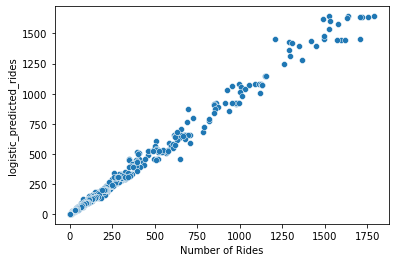

In [68]:
sns.scatterplot(x='Number of Rides', y='logistic_predicted_rides', data=normalized_ohe_data)

In [69]:
post_lockdown = oh_weekday_data[oh_weekday_data['day'] > 15]
# post_lockdown = normalized_ohe_data
# post_lockdown = post_lockdown.drop(col)
post_lockdown = post_lockdown.rename(columns={'day':'days_elapsed'})
post_lockdown['days_elapsed'] = post_lockdown['days_elapsed'] - 15
post_lockdown['days_elapsed'] = (post_lockdown['days_elapsed'] - post_lockdown['days_elapsed'].mean()) / post_lockdown['days_elapsed'].std()
post_lockdown['days_elapsed_log'] = 1 / (1 + np.exp(post_lockdown['days_elapsed']))
post_lockdown['predicted_normalized_rides'] = f(post_lockdown['days_elapsed'], popt[0], popt[1], popt[2], popt[3])
post_lockdown['normalized_rides'] = (post_lockdown['Number of Rides'] - post_lockdown['Number of Rides'].mean()) / post_lockdown['Number of Rides'].std()
post_lockdown.head(35)

In [ ]:
sns.scatterplot(data=post_lockdown, x='predicted_normalized_rides', y='normalized_rides')

In [ ]:
post_lockdown = post_lockdown.iloc[:, 1:]
post_lockdown.columns

In [ ]:
from sklearn.model_selection import train_test_split
post_lockdown_train, post_lockdown_test = train_test_split(post_lockdown, test_size=0.1, random_state=83)
post_lockdown_train.head()
X_train, y_train = post_lockdown_train.drop(columns=['Number of Rides']), post_lockdown_train['Number of Rides']
X_test, y_test = post_lockdown_test.drop(columns=['Number of Rides']), post_lockdown_test['Number of Rides']

In [ ]:
traffic_model = LinearRegression()
traffic_model.fit(X_train, y_train)
y_pred = traffic_model.predict(X_train)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
print('MSE on training data:', mean_squared_error(y_train, y_pred))
print('r2 score on training data:', r2_score(y_train, y_pred))

In [ ]:
plt.scatter(y_train, y_pred);

In [ ]:
pd.Series(y_pred).describe()

In [ ]:
pd.Series(y_train).describe()

In [ ]:
print('MSE on test data:', mean_squared_error(y_test, traffic_model.predict(X_test)))
print('r2 score on test data:', r2_score(y_test, traffic_model.predict(X_test)))

In [ ]:
normalized_rides = oh_weekday_data.groupby('Business Category')[['Number of Rides']].transform(lambda x: (x - x.mean()) / x.std())
normalized_rides['Business Category'] = oh_weekday_data['Business Category']
normalized_rides['day'] = oh_weekday_data['day']
normalized_rides.head()

In [70]:
sns.scatterplot(x='day', y='Number of Rides', data=normalized_rides)

In [ ]:
import scipy

x = np.array(normalized_rides['day'])
y = np.array(normalized_rides['Number of Rides'])

def f(x, a, b, c, d):
    return a / (1 + np.exp(-c * (x-d))) + b

popt, pcov = scipy.optimize.curve_fit(f, x, y, method='trf')
y_fit = f(x, *popt)
sns.scatterplot(x, y)
sns.lineplot(x, y_fit)

popt

In [ ]:
y_fit

In [ ]:
import seaborn as sns

x = np.array(grouped_business_data['day'])
y = np.array(grouped_business_data['Number of Rides'])

sns.scatterplot(x, y)

In [ ]:
plt.plot(oh_weekday_data['day'], np.log(oh_weekday_data['Number of Rides']))

## Question 5b

Improve on your baseline model. Specify the model you designed and its input features. Justify why you chose these features and their relevance to your model's predictions.

**Example**

Here are potential questions to consider for this part: How does the other variant of your travel times dataset, aggregated across time but reported for all routes, useful?  What additional data from the Uber Movement website can you export to better your model?

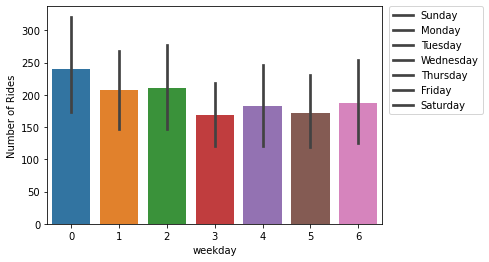

In [71]:
precovid = oh_weekday_data.loc[oh_weekday_data['day'] >=14 , :]
postcovid = oh_weekday_data.loc[oh_weekday_data["day"] < 14 , :]
sns.barplot(data=precovid , x ='weekday' , y='Number of Rides')
plt.legend(["Sunday" , "Monday" , "Tuesday" , "Wednesday" , "Thursday" , "Friday" , "Saturday"] , bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

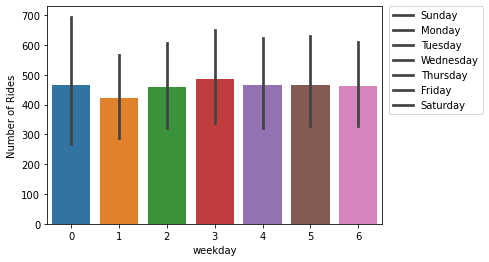

In [72]:
sns.barplot(data=postcovid , x ='weekday' , y='Number of Rides')
plt.legend(["Sunday" , "Monday" , "Tuesday" , "Wednesday" , "Thursday" , "Friday" , "Saturday"] , bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)


## Question 5c

Explore other modeling aspects and/or temporal information. You are free to relate this to your hypothesis or not. Please expand into multiple parts that logically separate and break down your modeling work!

**Example**

For example, explore change across time, before and after the lockdown: (a) train and evaluate on *pre*-lockdown traffic travel times for that route; and (b) evaluate your model on *post*-lockdown traffic patterns.
How would you correct your model for a more accurate post-lockdown traffic predictor? *The above is just a suggestion. You may pick any topic you find interesting.*

In [73]:
# Loading in Business Locations with all columns and doing data cleaning using pandas that Nathan did with excel
businesses_eda = pd.read_csv('data/Registered_Business_Locations_-_San_Francisco(1).csv')
businesses_eda = businesses_eda.rename(columns={'Latitude':'Longitude', 'Longitude':'Latitude'})
#remove non SF companies
businesses_eda = businesses_eda[businesses_eda["City"] == "San Francisco"]
# Convert Times to Date Format 
businesses_eda["Business End Date"] = pd.to_datetime(businesses_eda["Business End Date"])
businesses_eda["Business Start Date"] = pd.to_datetime(businesses_eda["Business Start Date"])
# There are 83482 rows of business that are no longer active in 2020. I dropped them here 
active_business = businesses_eda[(businesses_eda["Business End Date"].dt.year > 2020) | (np.isnat(businesses_eda["Business End Date"]))]
# Split Point Column to match 
split_coordinates = active_business["Business Location"].str.extract(r'\s\(([^\\]*)\)').iloc[: , 0].str.extract(r'(^[^\s]*)\s(.*)')
active_business= active_business.join(split_coordinates.astype(float))
# active_business["Latitude"] = split_coordinates.loc[: ,1].astype(float)
# Round to match columns
active_business = active_business.round(4)

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (12,13,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [74]:
park_eda = pd.read_csv('data/Recreation_and_Parks_Properties.csv')
park_eda = park_eda.round(4)
park_eda.head()

,OBJECTID,Map_Label,Longitude,Latitude,Acres,TMA_PropertyID,GlobalID,created_user,created_date,last_edited_user,...,Land_ID,GGP_Section,State_Senate,MONS_Neighborhood,Police_District,US_Congress,Realtor_Neighborhood,State_Assembly,Planning_Neighborhood,shape
0,1,Maritime Plaza,-122.3998,37.7955,2.0128,142,{C7DDE53A-9636-451E-AB81-6CD8EA8064BB},rpdgis,20130524085732,RPDGIS@RPDGIS.SFGOV.ORG,...,304.0,NaN,11th Senatorial District,Financial District,Central,12th Congressional District,Financial District/Barbary Coast,17th Assembly District,Financial District,MULTIPOLYGON (((-122.39907987164456 37.7959623...
1,3,Lake Merced Park,-122.4924,37.7219,608.4861,10,{293E53D2-335E-437A-91F0-542BA621ED4A},rpdgis,20130524085732,RPDGIS@RPDGIS.SFGOV.ORG,...,806.0,NaN,11th Senatorial District,Lakeshore,Taraval,14th Congressional District,Lake Shore,19th Assembly District,Lakeshore,MULTIPOLYGON (((-122.48623678253473 37.7081573...
2,6,Broadway Tunnel West Mini Park,-122.4174,37.7964,0.1490,203,{28E5A0C5-4251-467C-B590-683B55DB2E03},rpdgis,20130524085732,RPDGIS@RPDGIS.SFGOV.ORG,...,621.0,NaN,11th Senatorial District,Russian Hill,Central,12th Congressional District,Nob Hill,17th Assembly District,Russian Hill,MULTIPOLYGON (((-122.41757140658545 37.7964861...
3,7,Mt. Davidson Park,-122.4547,37.7391,40.7118,69,{6E125179-0B3B-4200-916A-1C98FF73A92A},rpdgis,20130524085732,RPDGIS@RPDGIS.SFGOV.ORG,...,121.0,NaN,11th Senatorial District,Miraloma Park,Ingleside,12th Congressional District,Miraloma Park,17th Assembly District,West of Twin Peaks,MULTIPOLYGON (((-122.45308566253199 37.7409742...
4,8,Union Square,-122.4075,37.7879,2.5997,135,{2B838818-7C4B-4841-8001-ACCB5B3B5469},rpdgis,20130524085732,RPDGIS@RPDGIS.SFGOV.ORG,...,243.0,NaN,11th Senatorial District,Downtown / Union Square,Central,12th Congressional District,Downtown,17th Assembly District,Downtown/Civic Center,MULTIPOLYGON (((-122.40672169413945 37.7876472...


In [75]:
covid_eda = pd.read_csv('data/COVID-19_Testing_Locations.csv')
split_coordinates_covid = covid_eda["point"].str.extract(r'\s\(([^\\]*)\)').iloc[: , 0].str.extract(r'(^[^\s]*)\s(.*)')
covid_eda = covid_eda.join(split_coordinates_covid.astype(float))
covid_eda = covid_eda.round(4)
covid_eda.head()

,ID,Medical Home,Name,Address,Phone Number,Phone Number Formatted,Testing Hours,Popup or Permanent,Location Type,Eligibility,...,Latitude,Longitude,point,Neighborhoods,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,0,1
0,1,Carbon Health,Carbon Health - Castro Clinic,1998 Market St,4.157926e+09,(415) 792-6040,9am-7pm,Permanent,Private,Must be Carbon Health patient,...,NaN,NaN,POINT (-122.425886 37.77001),27,27,1,5,9,-122.4259,37.7700
1,6,UCSF,Laurel Heights Campus,3333 California St,4.158857e+09,(415) 885-7478,9am-5pm M-F,Pop-Up,Private,Must be UCSF patient,...,NaN,NaN,POINT (-122.448645 37.786995),11,11,8,6,31,-122.4486,37.7870
2,11,Northeast Medical Services,San Bruno Ave Clinic,2574 San Bruno Ave,4.153920e+09,(415) 391-9686,8:30am-5pm M-F,Permanent,Private,Must be NEMS patient. May register as a new NE...,...,NaN,NaN,POINT (-122.404218 37.7291),91,91,2,2,25,-122.4042,37.7291
3,43,SF Department of Public Health in partnership ...,Alice Griffith,2600 Arelious Walker Dr,3.110000e+02,Dial 3-1-1,"Saturday, 11/20 only from 10am - 3pm",Pop-Up,Public,Everyone. No insurance required.,...,37.7187,-122.3849,POINT (-122.38494480000001 37.7187018),88,88,2,9,1,-122.3849,37.7187
4,25,SF Department of Public Health in partnership ...,GLIDE Memorial Church,330 Ellis Street,3.110000e+02,Dial 3-1-1,"Tuesdays & Wednesdays, 10am-4pm",Pop-Up,Public,Everyone. No insurance required.,...,37.7852,-122.4137,POINT (-122.413658 37.7852341),20,20,5,10,36,-122.4137,37.7852


In [76]:
merged_park_covid = covid_eda.merge(park_eda , )

In [77]:
#Merged the data sets
active_business_data = active_business.merge(speeds_to_gps, how='inner', left_on=[0, 1], right_on=['endLongitude', 'endLatitude'])
# Add weekday column (Needs fixing to assign day to number)
active_business_data["weekday"] = active_business_data['day'] % 7
#Add bar feature
active_business_data['has_bar'] = grouped.astype(int)

In [78]:
active_business_data

,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,...,Current Supervisor Districts,Analysis Neighborhoods,Neighborhoods,0,1,day,speed_mph_mean,endLongitude,endLatitude,weekday
0,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,10.0,8.0,108.0,-122.3975,37.7911,1,19.9821,-122.3975,37.7911,1
1,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,10.0,8.0,108.0,-122.3975,37.7911,2,18.4750,-122.3975,37.7911,2
2,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,10.0,8.0,108.0,-122.3975,37.7911,3,17.3012,-122.3975,37.7911,3
3,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,10.0,8.0,108.0,-122.3975,37.7911,4,17.1303,-122.3975,37.7911,4
4,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,10.0,8.0,108.0,-122.3975,37.7911,5,17.1456,-122.3975,37.7911,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148322,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,10.0,36.0,20.0,-122.4208,37.7829,28,23.8340,-122.4208,37.7829,0
148323,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,10.0,36.0,20.0,-122.4208,37.7829,29,23.3585,-122.4208,37.7829,1
148324,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,10.0,36.0,20.0,-122.4208,37.7829,30,19.1640,-122.4208,37.7829,2
148325,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,10.0,36.0,20.0,-122.4208,37.7829,30,17.7893,-122.4208,37.7829,2


In [79]:
grouped_business_active = active_business_data.groupby(['NAICS Code Description', 'day']).count()
grouped_business_active = grouped_business_active[['Neighborhoods']]
grouped_business_active.rename(columns={'Neighborhoods':'Number of Rides'}, inplace=True)


In [80]:
total_rides = active_business_data.groupby('day')['Location Id'].count().reset_index()

In [81]:
active_business_data.groupby('NAICS Code Description')['Location Id'].count().reset_index()

,NAICS Code Description,Location Id
0,Accommodations,2561
1,Administrative and Support Services,3044
2,"Arts, Entertainment, and Recreation",4724
3,Certain Services,4047
4,Construction,4463
5,Financial Services,6654
6,Food Services,15847
7,Information,4274
8,Insurance,1049
9,Manufacturing,736


In [82]:
total_rides.corr()

,day,Location Id
day,1.000000,-0.942488
Location Id,-0.942488,1.000000


In [84]:
grouped_business_active.reset_index().corr()

,day,Number of Rides
day,1.000000,-0.340474
Number of Rides,-0.340474,1.000000


In [85]:
# Reset index to better visluazie table
grouped_business_active = grouped_business_active.reset_index()
grouped_business_active.head()

,NAICS Code Description,day,Number of Rides
0,Accommodations,1,135
1,Accommodations,2,151
2,Accommodations,3,146
3,Accommodations,4,151
4,Accommodations,5,149


In [86]:
active_business

,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,...,Business Corridor,Business Location,UniqueID,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,Neighborhoods,0,1
0,0030032-46-001,30032,Walgreen Co,Walgreens #15567,845 Market St,San Francisco,CA,94103,1968-10-01,NaT,...,NaN,POINT (-122.40681 37.784874),0030032-46-001-0030032-4400-4599-01-24-2014,32.0,5.0,10.0,34.0,32.0,-122.4068,37.7849
3,0050145-01-001,50145,Gallina Luciana,3455 Fillmore St Apts,3455 Fillmore St,San Francisco,CA,94123,1969-01-09,NaT,...,NaN,POINT (-122.436516 37.801323),0050145-01-001-0050145-5300-5399-01-09-1969,17.0,4.0,6.0,13.0,17.0,-122.4365,37.8013
4,0108554-01-001,108554,Slavin Diana,Diana Slavin Womenswear,3 Claude Ln,San Francisco,CA,94108,1977-07-01,NaT,...,NaN,POINT (-122.40427 37.789883),0108554-01-001-0108554-4400-4599-07-01-1977,19.0,6.0,3.0,8.0,19.0,-122.4043,37.7899
5,0112884-02-001,112884,Creighton Inc,Donahues Marina Lounge,2138 Chestnut St,San Francisco,CA,94123,1978-07-01,NaT,...,NaN,POINT (-122.438545 37.800552),0112884-02-001-0112884-4400-4599-01-01-1996,17.0,4.0,6.0,13.0,17.0,-122.4385,37.8006
6,1121572-09-161,113585,Arch Drafting Supply Inc,Arch Drafting Supply Inc,10 Carolina St,San Francisco,CA,94103,1978-09-15,NaT,...,NaN,POINT (-122.40093 37.768253),1121572-09-161-0113585-4400-4599-09-01-2016,33.0,1.0,9.0,4.0,33.0,-122.4009,37.7683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282513,1265684-12-201,1119746,Candice Williams,Masque'd Up,1 Westbrook Ct,San Francisco,CA,94124,2020-12-01,NaT,...,NaN,POINT (-122.38183 37.73491),1265684-12-201-1119746-4400-4599-12-01-2020,86.0,2.0,9.0,1.0,86.0,-122.3818,37.7349
282514,1264486-11-201,1119252,Marco Flores,Marco Flores,659 Paris St,San Francisco,CA,94112,2020-11-24,NaT,...,NaN,POINT (-122.43744 37.71837),1264486-11-201-1119252-2300-2399-11-24-2020,90.0,9.0,1.0,7.0,90.0,-122.4374,37.7184
282515,1266294-12-201,1119989,Travis Somers,T A Somers Electrical,1356 45th Ave Ave,San Francisco,CA,94122,2020-12-18,2021-03-15,...,NaN,POINT (-122.50488 37.761284),1266294-12-201-1119989-5400-5499-12-18-2020,39.0,10.0,7.0,35.0,39.0,-122.5049,37.7613
282516,1263397-11-201,1118795,"Specialty's 150 Spear, Llc","Specialty's 150 Spear, Llc",150 Spear St,San Francisco,CA,94105-1535,2020-11-03,NaT,...,NaN,POINT (-122.3933 37.791893),1263397-11-201-1118795-7220-7229-11-03-2020,108.0,1.0,10.0,8.0,108.0,-122.3933,37.7919


Text(0.5, 1.0, 'Number of rides to different business categories in March 2020')

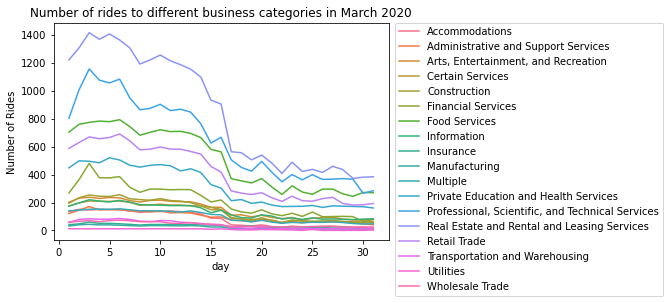

In [87]:
sns.lineplot(data = grouped_business_active , x='day' , y='Number of Rides' , hue='NAICS Code Description' , legend=False)
plt.legend(grouped_business_active["NAICS Code Description"].unique() , bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.title("Number of rides to different business categories in March 2020")

In [108]:
def pickup_scatter(t):
    plt.scatter(t['endLongitude'], t['endLatitude'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')

In [109]:
D = speeds_to_gps[['endLongitude', 'endLatitude']]
pca_means =  np.mean(D, axis=0)
X = (D - pca_means)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[['endLongitude', 'endLatitude']]
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = (D - pca_means) 
    first_pc = X@ vt.T[:, 0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
add_region(speeds_to_gps)

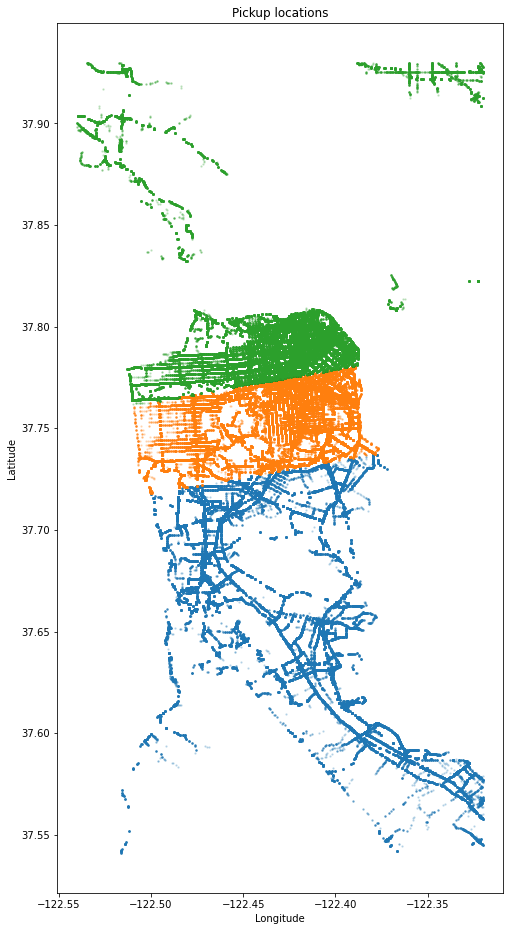

In [111]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(speeds_to_gps[speeds_to_gps['region'] == i])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Accommodations'),
  Text(1, 0, 'Administrative and Support Services'),
  Text(2, 0, 'Arts, Entertainment, and Recreation'),
  Text(3, 0, 'Certain Services'),
  Text(4, 0, 'Construction'),
  Text(5, 0, 'Financial Services'),
  Text(6, 0, 'Food Services'),
  Text(7, 0, 'Information'),
  Text(8, 0, 'Insurance'),
  Text(9, 0, 'Manufacturing'),
  Text(10, 0, 'Multiple'),
  Text(11, 0, 'Private Education and Health Services'),
  Text(12, 0, 'Professional, Scientific, and Technical Services'),
  Text(13, 0, 'Real Estate and Rental and Leasing Services'),
  Text(14, 0, 'Retail Trade'),
  Text(15, 0, 'Transportation and Warehousing'),
  Text(16, 0, 'Utilities'),
  Text(17, 0, 'Wholesale Trade')])

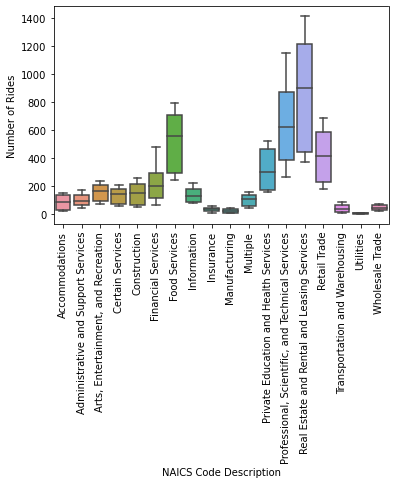

In [96]:
sns.boxplot(data= grouped_business_active , x="NAICS Code Description" , y='Number of Rides')
plt.xticks(rotation=90)

In [115]:
#Merged the data sets
active_business_data = active_business.merge(speeds_to_gps, how='inner', left_on=[0, 1], right_on=['endLongitude', 'endLatitude'])
# Add weekday column (Needs fixing to assign day to number)
active_business_data["weekday"] = active_business_data['day'] % 7
#Add bar feature
active_business_data['has_bar'] = grouped.astype(int)
active_business_data

,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,...,Neighborhoods,0,1,day,speed_mph_mean,endLongitude,endLatitude,region,weekday,has_bar
0,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,1,19.9821,-122.3975,37.7911,2,1,0
1,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,2,18.4750,-122.3975,37.7911,2,2,0
2,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,3,17.3012,-122.3975,37.7911,2,3,0
3,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,4,17.1303,-122.3975,37.7911,2,4,0
4,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,5,17.1456,-122.3975,37.7911,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148322,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,20.0,-122.4208,37.7829,28,23.8340,-122.4208,37.7829,2,0,0
148323,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,20.0,-122.4208,37.7829,29,23.3585,-122.4208,37.7829,2,1,0
148324,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,20.0,-122.4208,37.7829,30,19.1640,-122.4208,37.7829,2,2,0
148325,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,20.0,-122.4208,37.7829,30,17.7893,-122.4208,37.7829,2,2,0


In [ ]:
#Merged the data sets
active_business_data = active_business.merge(speeds_to_gps, how='inner', left_on=[0, 1], right_on=['endLongitude', 'endLatitude'])
# Add weekday column (Needs fixing to assign day to number)
active_business_data["weekday"] = active_business_data['day'] % 7
#Add bar feature
active_business_data['has_bar'] = grouped.astype(int)

In [146]:
active_business_data

,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,Business Start Date,Business End Date,...,Neighborhoods,0,1,day,speed_mph_mean,endLongitude,endLatitude,region,weekday,has_bar
0,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,1,19.9821,-122.3975,37.7911,2,1,0
1,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,2,18.4750,-122.3975,37.7911,2,2,0
2,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,3,17.3012,-122.3975,37.7911,2,3,0
3,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,4,17.1303,-122.3975,37.7911,2,4,0
4,1288023-09-211,44933,"Aramark Services, Inc.",Aramark Rfs At Salesforce,50 Fremont St Fl 30,San Francisco,CA,94105,2002-01-01,NaT,...,108.0,-122.3975,37.7911,5,17.1456,-122.3975,37.7911,2,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148322,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,20.0,-122.4208,37.7829,28,23.8340,-122.4208,37.7829,2,0,0
148323,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,20.0,-122.4208,37.7829,29,23.3585,-122.4208,37.7829,2,1,0
148324,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,20.0,-122.4208,37.7829,30,19.1640,-122.4208,37.7829,2,2,0
148325,1266172-12-201,1119939,Faisal Dheg Muse,Linguistic,Eddy St St Apt 111,San Francisco,CA,94109,2020-12-29,NaT,...,20.0,-122.4208,37.7829,30,17.7893,-122.4208,37.7829,2,2,0


In [139]:
region1 = active_business_data.loc[active_business_data['region'] == 0 , :]
region2 = active_business_data.loc[active_business_data['region'] == 1 , :]
region3 = active_business_data.loc[active_business_data['region'] == 2 , :]
count1 = region1.groupby(['NAICS Code Description', 'day']).count().reset_index()
count2 = region2.groupby(['NAICS Code Description', 'day']).count().reset_index()
count3 = region3.groupby(['NAICS Code Description', 'day']).count().reset_index()
count2

,NAICS Code Description,day,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,...,Analysis Neighborhoods,Neighborhoods,0,1,speed_mph_mean,endLongitude,endLatitude,region,weekday,has_bar
0,Accommodations,1,49,49,49,49,49,49,49,49,...,49,49,49,49,49,49,49,49,49,49
1,Accommodations,2,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
2,Accommodations,3,51,51,51,51,51,51,51,51,...,51,51,51,51,51,51,51,51,51,51
3,Accommodations,4,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
4,Accommodations,5,54,54,54,54,54,54,54,54,...,54,54,54,54,54,54,54,54,54,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,Wholesale Trade,27,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
554,Wholesale Trade,28,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
555,Wholesale Trade,29,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
556,Wholesale Trade,30,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

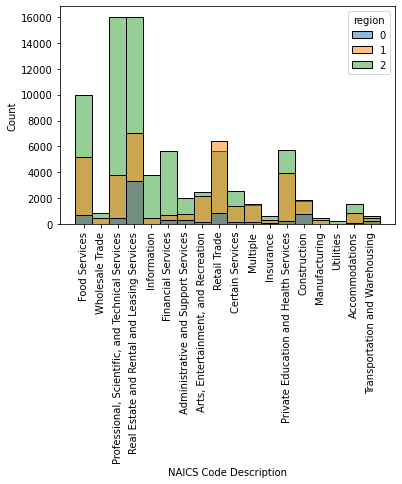

In [145]:

sns.histplot(data=active_business_data,  x=active_business_data['NAICS Code Description'] , hue='region')
plt.xticks(rotation=90)
# plt.legend()

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

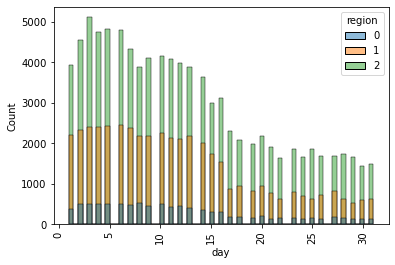

In [147]:
sns.histplot(data=active_business_data,  x=active_business_data['day'] , hue='region')
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

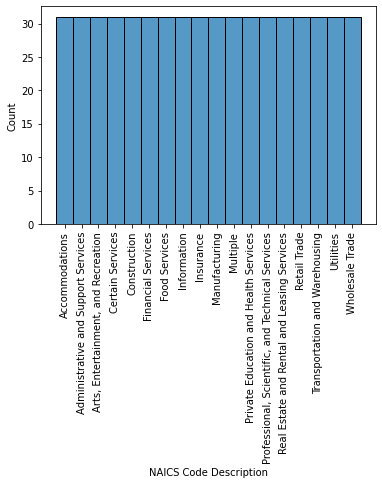

In [137]:
sns.histplot(count2 ,  x=count2['NAICS Code Description'])
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

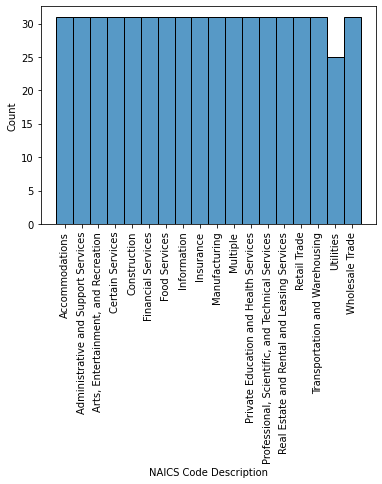

In [138]:
sns.histplot(count3 ,  x=count3['NAICS Code Description'])
plt.xticks(rotation=90)

In [125]:
count3[count3['Location Id'] < 0]

,NAICS Code Description,day,Location Id,Business Account Number,Ownership Name,DBA Name,Street Address,City,State,Source Zipcode,...,Analysis Neighborhoods,Neighborhoods,0,1,speed_mph_mean,endLongitude,endLatitude,region,weekday,has_bar


In [ ]:
region1 = active_business_data.loc[(active_business_data['region'] == 0) & (train['period'] == 3) , :]
region2 = train.loc[(train['region'] == 1) & (train['period'] == 3) , :]
region3 = train.loc[(train['region'] == 2) & (train['period'] == 3), :]
sns.distplot(region1 ,  x=region1['speed'])
sns.distplot(region2 ,  x=region2['speed'])
sns.distplot(region3 ,  x=region3['speed'])
plt.xlabel("speed")

In [88]:
grouped_business_active["NAICS Code Description"].unique()

array(['Accommodations', 'Administrative and Support Services',
       'Arts, Entertainment, and Recreation', 'Certain Services',
       'Construction', 'Financial Services', 'Food Services',
       'Information', 'Insurance', 'Manufacturing', 'Multiple',
       'Private Education and Health Services',
       'Professional, Scientific, and Technical Services',
       'Real Estate and Rental and Leasing Services', 'Retail Trade',
       'Transportation and Warehousing', 'Utilities', 'Wholesale Trade'],
      dtype=object)

In [89]:
eda_business = active_business_data.copy()


In [90]:
#Built Feature for Bars 
grouped = eda_business["DBA Name"].str.lower().str.split(' ').explode().str.fullmatch('bar|club|pub').to_frame().reset_index().groupby(['index']).apply(lambda x: (x["DBA Name"]==True).any())

In [91]:
grouped = eda_business["DBA Name"].str.lower().str.split(' ').explode().str.fullmatch('bar|club|pub').to_frame().reset_index().groupby(['index']).apply(lambda x: (x["DBA Name"]==True).any())

In [92]:
grouped_stadium = eda_business["DBA Name"].str.lower().str.split(' ').explode().str.fullmatch('stadium|center').to_frame().reset_index().groupby(['index']).apply(lambda x: (x["DBA Name"]==True).any())


KeyboardInterrupt: 

In [ ]:
eda_business[grouped_stadium]

In [ ]:
eda_business['has_bar'] = grouped.astype(int)
eda_business.loc[eda_business['has_bar'] == 1 , 'NAICS Code Description'] = "Bar"

In [ ]:
grouped_business_active = eda_business.groupby(['NAICS Code Description', 'day']).count()
grouped_business_active = grouped_business_active[['Neighborhoods']]
grouped_business_active.rename(columns={'Neighborhoods':'Number of Rides'}, inplace=True)


In [ ]:
grouped_business_active = grouped_business_active.reset_index()
grouped_business_active.head()

In [ ]:
grouped_day = eda_business.groupby(["weekday" , "NAICS Code Description"]).count()[["Location Id"]]


In [ ]:
grouped_day.reset_index()

In [ ]:
sns.barplot(data = grouped_day , x='NAICS Code Description' , y='Location Id', hue='weekday')
plt.legend().remove()

In [ ]:
# Same setup as before
from sklearn.preprocessing import OneHotEncoder
oh_category = OneHotEncoder()
oh_category.fit(grouped_business_active[['NAICS Code Description']])
oh_category.get_feature_names()
oh_category_data = grouped_business_active.join(pd.DataFrame(oh_category.transform(grouped_business_active[['NAICS Code Description']]).todense(), 
                           columns=oh_category.get_feature_names(),
                           index = grouped_business_active.index))
oh_category_data.head()
oh_category_data['weekday'] = oh_category_data['day'] % 7
oh_weekday = OneHotEncoder()
oh_weekday.fit(oh_category_data[['weekday']])
oh_weekday.get_feature_names()
oh_weekday_data = oh_category_data.join(pd.DataFrame(oh_weekday.transform(oh_category_data[['weekday']]).todense(), 
                           columns=oh_weekday.get_feature_names(),
                           index = oh_category_data.index))
oh_weekday_data.head()
normalized_ohe_data = oh_weekday_data.copy()
category_std = normalized_ohe_data.groupby('NAICS Code Description')[['Number of Rides']].transform(lambda x: np.std(x))
category_mean = normalized_ohe_data.groupby('NAICS Code Description')[['Number of Rides']].transform(lambda x: np.mean(x))

normalized_ohe_data['category_std'] = category_std
normalized_ohe_data['category_mean'] = category_mean
normalized_ohe_data['normalized_predicted_rides'] = -2.222 / (1 + np.exp(-0.513 * (normalized_ohe_data['day'] - 15.431))) + 1.152
normalized_ohe_data['logistic_predicted_rides'] = normalized_ohe_data['normalized_predicted_rides'] * normalized_ohe_data['category_std'] + normalized_ohe_data['category_mean']

In [ ]:
normalized_ohe_data[normalized_ohe_data['NAICS Code Description'] == "Bar"]

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
normalized_ohe_data.corr()

In [ ]:
grader.check_all()

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export()